In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize': (15, 8)})
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random as rd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot
import warnings

In [2]:
from pathlib import Path
from zipfile import ZipFile
import os


def join_split_zip_files(split_zip_files_directory: str, destination_dir: str = './temp/', zip_filename: str = 'temp.zip') -> None:
    split_zip_files = os.listdir(split_zip_files_directory)
    zip_filepath = os.path.join(destination_dir, zip_filename)
    if os.path.isfile(zip_filepath):
        os.remove(zip_filepath)
    for split_zip_file in split_zip_files:
        with open(zip_filepath, "ab") as zip_file:
            with open(os.path.join(split_zip_files_directory, split_zip_file), "rb") as split_zip:
                zip_file.write(split_zip.read())
    return zip_filepath


def unzip_file(zip_filepath: str, destination_dir: str) -> None:
    with ZipFile(zip_filepath, 'r') as zipfile:
        zipfile.extractall(destination_dir)


def unzip_required_asset(filepath: str, zip_path: str, destination_dir: str) -> None:
    if not os.path.isfile(filepath):
        if os.path.isfile(zip_path):
            unzip_file(zip_path, destination_dir)
        elif os.path.isdir(zip_path):
            zip_filepath = join_split_zip_files(zip_path, destination_dir)
            unzip_file(zip_filepath, destination_dir)
            os.remove(zip_filepath)


In [3]:
shortlist_coutries = [
    'Argentina', 'Australia', 'Brazil', 'Canada', 'China', 'Colombia', 'Egypt',
    'Ethiopia', 'France', 'Germany', 'India', 'Ireland', 'Italy', 'Kenya',
    'Mexico', 'Nigeria', 'Russian Federation', 'Spain',
    'United Kingdom of Great Britain and Northern Ireland',
    'United States of America'
]

continents = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

cont_region = [
    'Eastern Africa', 'Middle Africa', 'Northern Africa', 'Southern Africa',
    'Western Africa', 'Northern America', 'Central America', 'Caribbean',
    'South America', 'Central Asia', 'Eastern Asia', 'Southern Asia',
    'South-eastern Asia', 'Western Asia', 'Eastern Europe', 'Northern Europe',
    'Southern Europe', 'Western Europe', 'Oceania'
]

In [4]:
vp_beef = ['Meat indigenous, cattle', 'Meat, cattle']

In [5]:
filepath = './../temp/value-of-production.csv'
zip_filepath = './../assets/value-of-production.zip'
temp_directory= './../temp'
unzip_required_asset(filepath, zip_filepath, temp_directory)

In [6]:
vp = pd.read_csv(filepath, encoding='latin1')
vp = vp.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'],
             axis=1)
vp = vp.loc[vp.Area.isin(shortlist_coutries)]
vp = vp.loc[vp.Item.isin(vp_beef)]
vp = vp.sort_values(by=["Area", "Item", "Year"])
vp.reset_index(inplace=True, drop=True)
vp

#SLC standing for Standard Local Currency will require conversion.

,Area,Item,Element,Year,Unit,Value
0,Argentina,"Meat indigenous, cattle",Gross Production Value (constant 2014-2016 tho...,1961,1000 Int. $,9384083.0
1,Argentina,"Meat indigenous, cattle",Gross Production Value (constant 2014-2016 tho...,1961,1000 SLC,116790662.0
2,Argentina,"Meat indigenous, cattle",Gross Production Value (constant 2014-2016 tho...,1961,1000 US$,10699645.0
3,Argentina,"Meat indigenous, cattle",Gross Production Value (constant 2014-2016 tho...,1962,1000 Int. $,10457032.0
4,Argentina,"Meat indigenous, cattle",Gross Production Value (constant 2014-2016 tho...,1962,1000 SLC,130144169.0
...,...,...,...,...,...,...
7563,United States of America,"Meat, cattle",Gross Production Value (constant 2014-2016 tho...,2018,1000 SLC,66012248.0
7564,United States of America,"Meat, cattle",Gross Production Value (current thousand US$),2018,1000 US$,54343317.0
7565,United States of America,"Meat, cattle",Gross Production Value (constant 2014-2016 tho...,2018,1000 US$,66012248.0
7566,United States of America,"Meat, cattle",Gross Production Value (constant 2014-2016 tho...,2019,1000 SLC,66712100.0


In [7]:
trade_cl_beef = ['Meat, beef and veal sausages', 'Meat, beef, preparations', 'Meat, cattle',
       'Meat, cattle, boneless (beef & veal)']

In [8]:
filepath = './../temp/trade-crops-livestock.csv'
zip_filepath = './../assets/trade-crops-livestock/'
temp_directory= './../temp'
unzip_required_asset(filepath, zip_filepath, temp_directory)

In [9]:
trade_cl = pd.read_csv(filepath, encoding='latin1')
trade_cl = trade_cl.drop(
    ['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
trade_cl = trade_cl.loc[trade_cl.Area.isin(shortlist_coutries)]
trade_cl = trade_cl.loc[trade_cl.Item.isin(trade_cl_beef)]
trade_cl = trade_cl.sort_values(by=["Area", "Item", "Year"])
trade_cl.reset_index(inplace=True, drop=True)
trade_cl.sample(5)

,Area,Item,Element,Year,Unit,Value
7201,Germany,"Meat, cattle, boneless (beef & veal)",Import Value,1979,1000 US$,310457.0
3447,China,"Meat, beef, preparations",Import Value,2020,1000 US$,110527.0
13667,United States of America,"Meat, beef, preparations",Import Value,1990,1000 US$,209000.0
3912,China,"Meat, cattle, boneless (beef & veal)",Export Quantity,2016,tonnes,68666.0
1903,Brazil,"Meat, cattle, boneless (beef & veal)",Import Value,1961,1000 US$,0.0


In [10]:
trade_cl.Unit.unique()

array(['tonnes', '1000 US$'], dtype=object)

In [11]:
trade_cl.Item.unique()

array(['Meat, beef, preparations', 'Meat, cattle',
       'Meat, cattle, boneless (beef & veal)',
       'Meat, beef and veal sausages'], dtype=object)

In [12]:
trade_cl.Element.unique()

array(['Import Quantity', 'Import Value', 'Export Quantity',
       'Export Value'], dtype=object)

In [13]:
trade_cl.isnull().sum()

Area         0
Item         0
Element      0
Year         0
Unit         0
Value      384
dtype: int64

# SUA_CROPS_LIVE

In [14]:
sua_beef = ['Meat, cattle']

#sua_beef = ['Beef and Buffalo Meat', 'Beef Mutton Pigmeat Prim''Meat, beef and veal sausages',
#'Meat, beef, dried, salted, smoked', 'Meat, beef, preparations', 'Meat, cattle',
#'Meat, cattle, boneless (beef & veal)', 'Beef and Buffalo Meat', 'Beef Mutton Pigmeat Prim']

In [15]:
filepath = './../temp/sua-crops-livestock.csv'
zip_filepath = './../assets/sua-crops-livestock.zip'
temp_directory= './../temp'
unzip_required_asset(filepath, zip_filepath, temp_directory)

sua = pd.read_csv(filepath, encoding='latin1')
sua = sua.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'],
               axis=1)
sua = sua.loc[sua.Area.isin(shortlist_coutries)]
sua = sua.loc[sua.Item.isin(sua_beef)]
sua = sua.sort_values(by=["Area", "Item", "Year"])
sua.reset_index(inplace=True, drop=True)
sua

,Area,Item,Element,Year,Unit,Value
0,Argentina,"Meat, cattle",Opening stocks,2010,tonnes,563579.0
1,Argentina,"Meat, cattle",Production,2010,tonnes,2630163.0
2,Argentina,"Meat, cattle",Import Quantity,2010,tonnes,1722.0
3,Argentina,"Meat, cattle",Stock Variation,2010,tonnes,0.0
4,Argentina,"Meat, cattle",Export Quantity,2010,tonnes,2600.0
...,...,...,...,...,...,...
2556,United States of America,"Meat, cattle",Export Quantity,2019,tonnes,130431.0
2557,United States of America,"Meat, cattle",Loss,2019,tonnes,0.0
2558,United States of America,"Meat, cattle",Processed,2019,tonnes,12344283.0
2559,United States of America,"Meat, cattle",Other uses (non-food),2019,tonnes,0.0


In [16]:
categories = ['Production', 'Import Quantity', 'Export Quantity']
sua_prod_imp_exp = sua.loc[sua.Element.isin(categories)]
sua_prod_imp_exp.reset_index(inplace=True,drop=True)

In [17]:
sua_prod_imp_exp.Item.unique()

array(['Meat, cattle'], dtype=object)

In [18]:
sua_filled_df = pd.DataFrame(columns=sua_prod_imp_exp.columns)

for country in tqdm(list(sua_prod_imp_exp.Area.unique())):
    for type_of_meat in list(sua_prod_imp_exp.Item.unique()):
        for element in list(sua_prod_imp_exp.Element.unique()):
            temp_df = sua_prod_imp_exp.loc[
                (sua_prod_imp_exp.Area == country)
                & (sua_prod_imp_exp.Item == type_of_meat) &
                (sua_prod_imp_exp.Element == element)]
            temp_df.fillna(temp_df.Value.mean(), inplace=True)
            sua_filled_df = sua_filled_df.append(temp_df)
            sua_filled_df.reset_index(inplace=True, drop=True)

sua_filled_df.dropna(inplace=True)
sua_filled_df.isnull().sum()
sua_filled_df.reset_index(inplace=True, drop=True)

  0%|                                                                                           | 0/19 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 62.71it/s]


In [19]:
sua_filled_df

,Area,Item,Element,Year,Unit,Value
0,Argentina,"Meat, cattle",Production,2010,tonnes,2630163.0
1,Argentina,"Meat, cattle",Production,2011,tonnes,2498954.0
2,Argentina,"Meat, cattle",Production,2012,tonnes,2595815.0
3,Argentina,"Meat, cattle",Production,2013,tonnes,2821608.0
4,Argentina,"Meat, cattle",Production,2014,tonnes,2674000.0
...,...,...,...,...,...,...
551,United States of America,"Meat, cattle",Export Quantity,2015,tonnes,111415.0
552,United States of America,"Meat, cattle",Export Quantity,2016,tonnes,119348.0
553,United States of America,"Meat, cattle",Export Quantity,2017,tonnes,128586.0
554,United States of America,"Meat, cattle",Export Quantity,2018,tonnes,137348.0


In [20]:
sua_filled_df["1000 Tonnes"] = sua_filled_df["Value"] / 1000
sua_filled_df

,Area,Item,Element,Year,Unit,Value,1000 Tonnes
0,Argentina,"Meat, cattle",Production,2010,tonnes,2630163.0,2630.163
1,Argentina,"Meat, cattle",Production,2011,tonnes,2498954.0,2498.954
2,Argentina,"Meat, cattle",Production,2012,tonnes,2595815.0,2595.815
3,Argentina,"Meat, cattle",Production,2013,tonnes,2821608.0,2821.608
4,Argentina,"Meat, cattle",Production,2014,tonnes,2674000.0,2674.000
...,...,...,...,...,...,...,...
551,United States of America,"Meat, cattle",Export Quantity,2015,tonnes,111415.0,111.415
552,United States of America,"Meat, cattle",Export Quantity,2016,tonnes,119348.0,119.348
553,United States of America,"Meat, cattle",Export Quantity,2017,tonnes,128586.0,128.586
554,United States of America,"Meat, cattle",Export Quantity,2018,tonnes,137348.0,137.348


In [21]:
def plot(df, element, region, meat_type="Meat, Cattle"):
    df = df.loc[(df.Element == element) & (df.Area == region)]
    df.reset_index(inplace=True, drop=True)
    sns.set(rc={'figure.figsize': (25, 12)})  #Set figure size
    sns.lineplot(x='Year', y='1000 Tonnes',
                 data=df[["Year", "1000 Tonnes"]]).set_title(
                     "Region: {0} - Trade: {1} (Thousand Tonnes).".format(
                         region, meat_type))  #Plot
    plt.show()

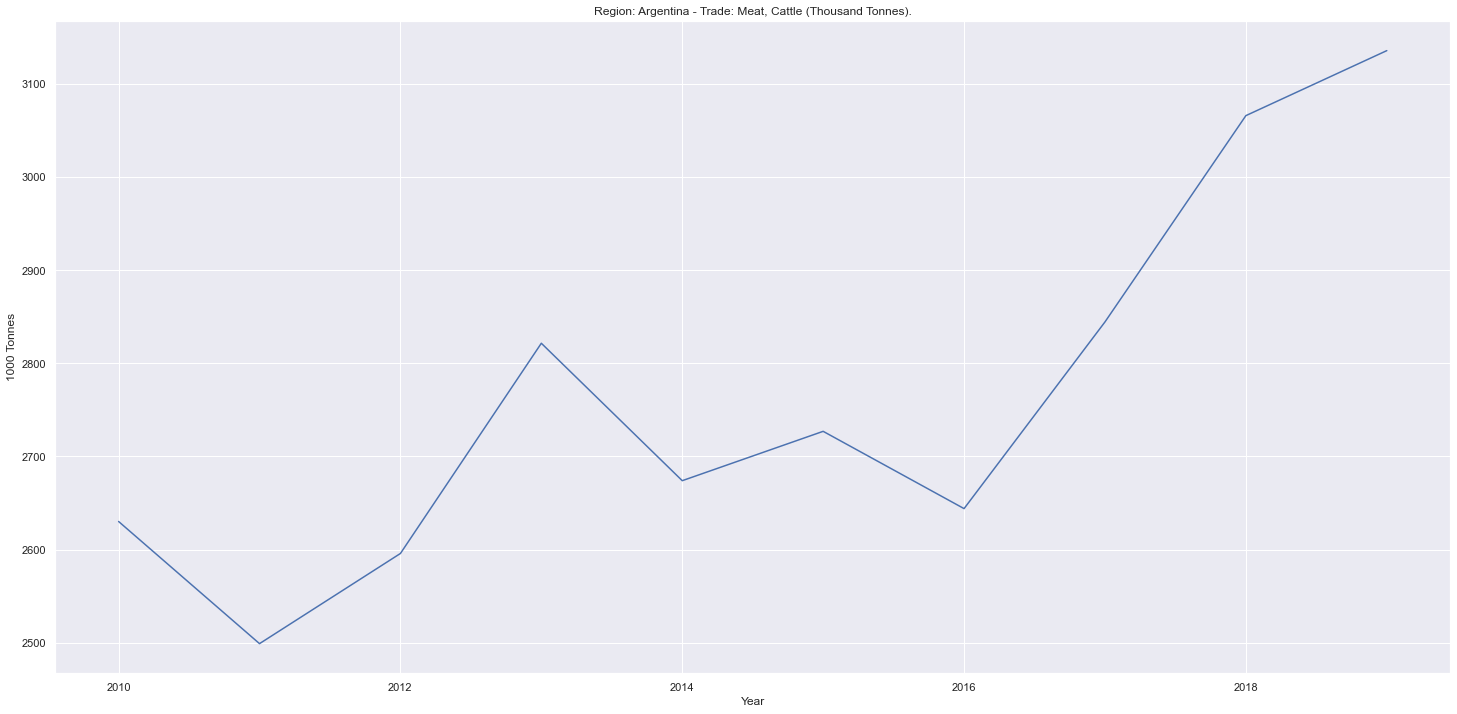

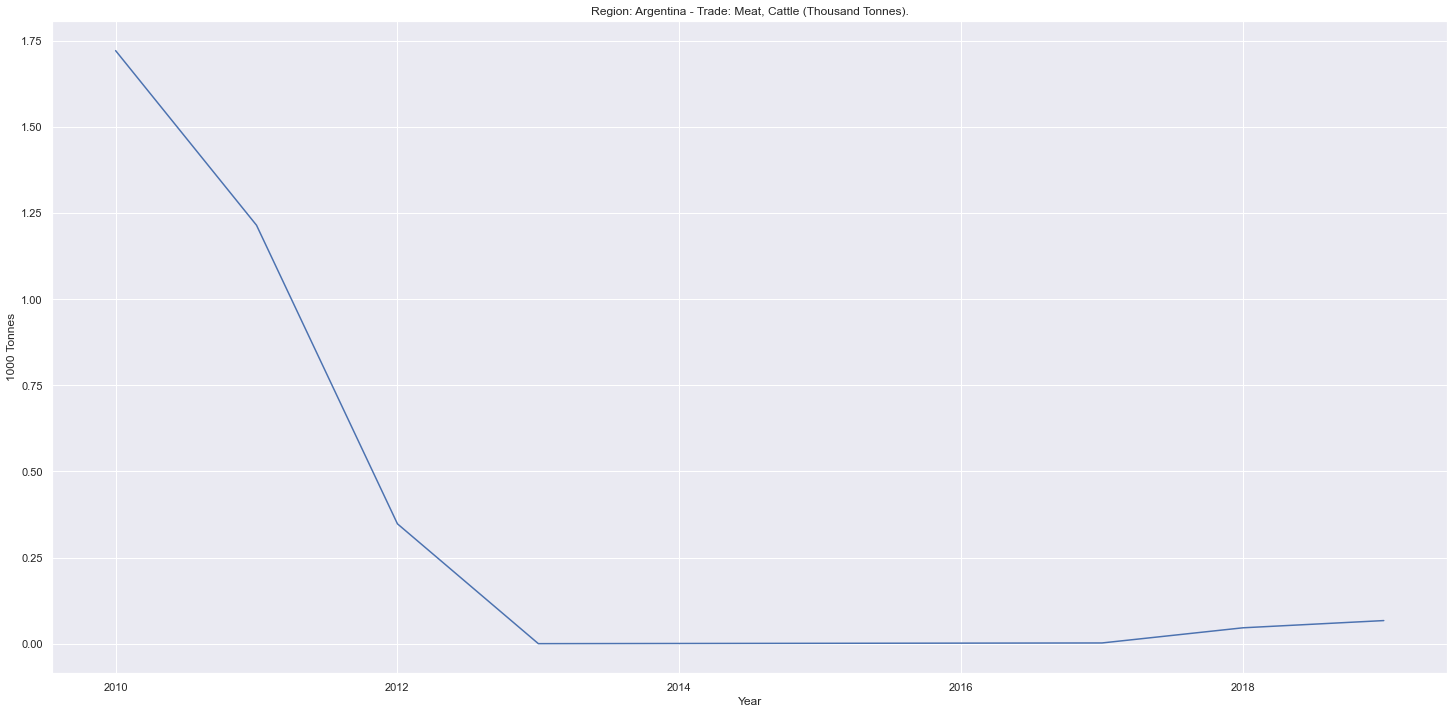

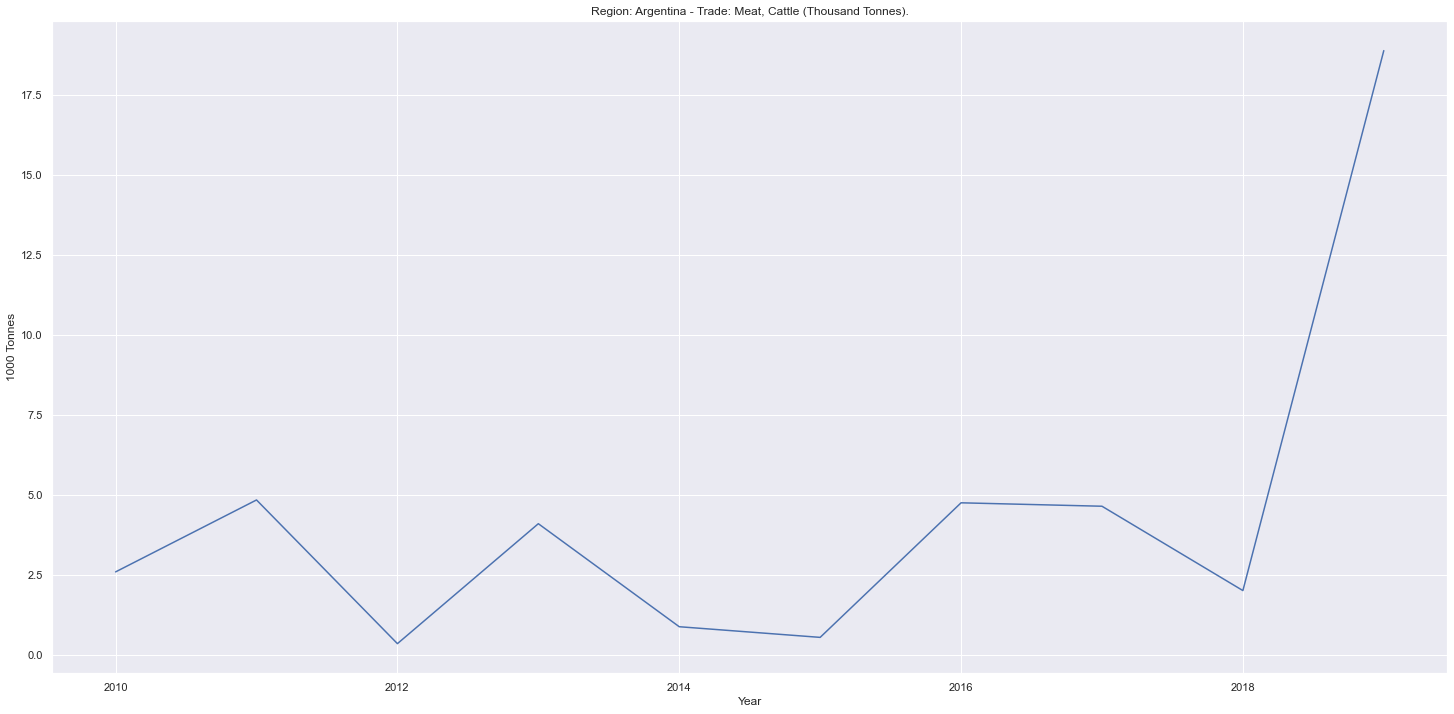

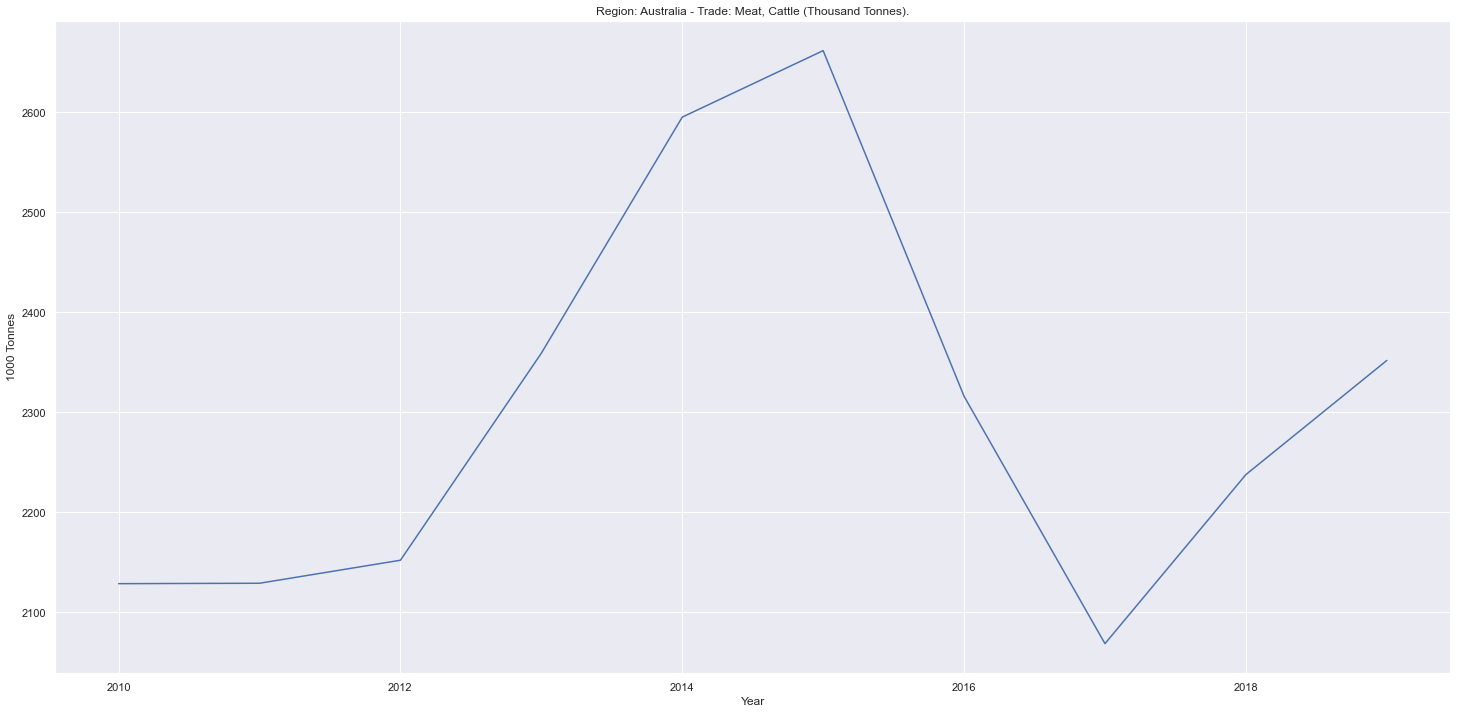

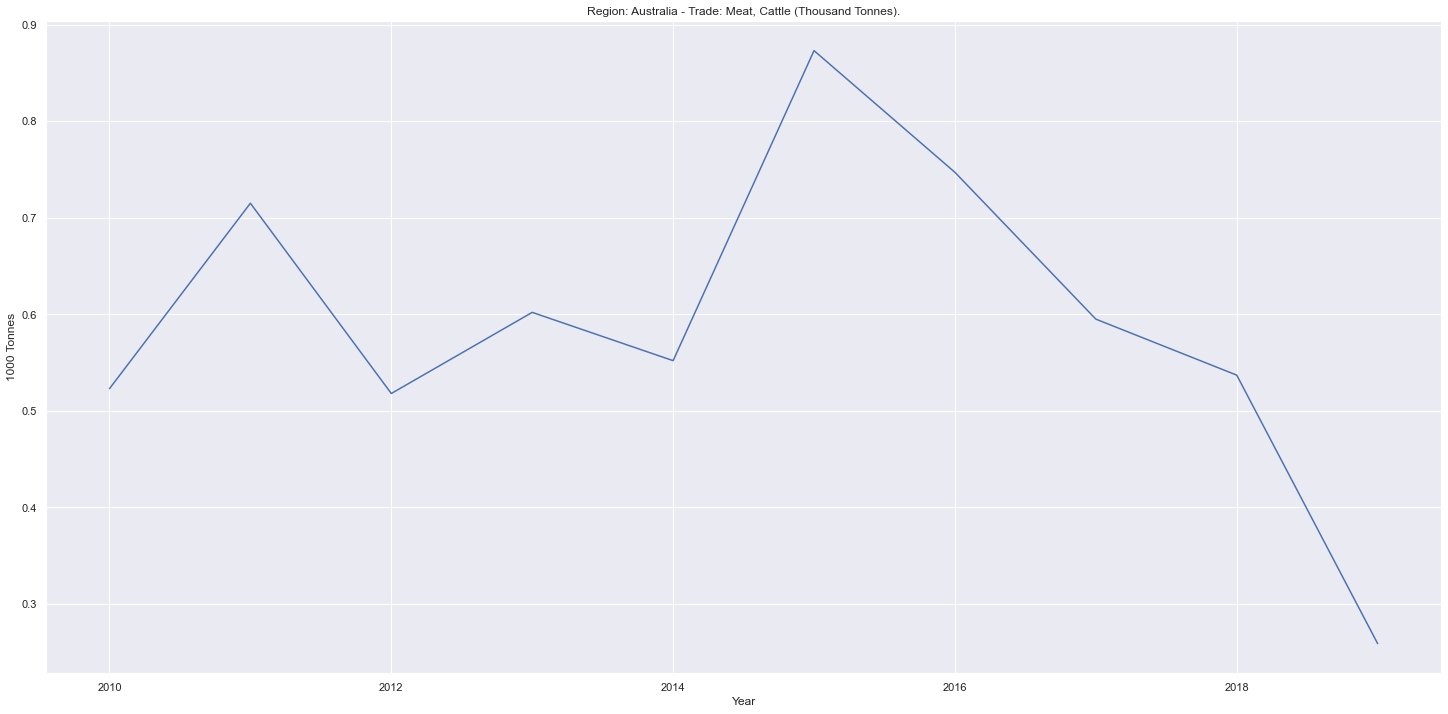

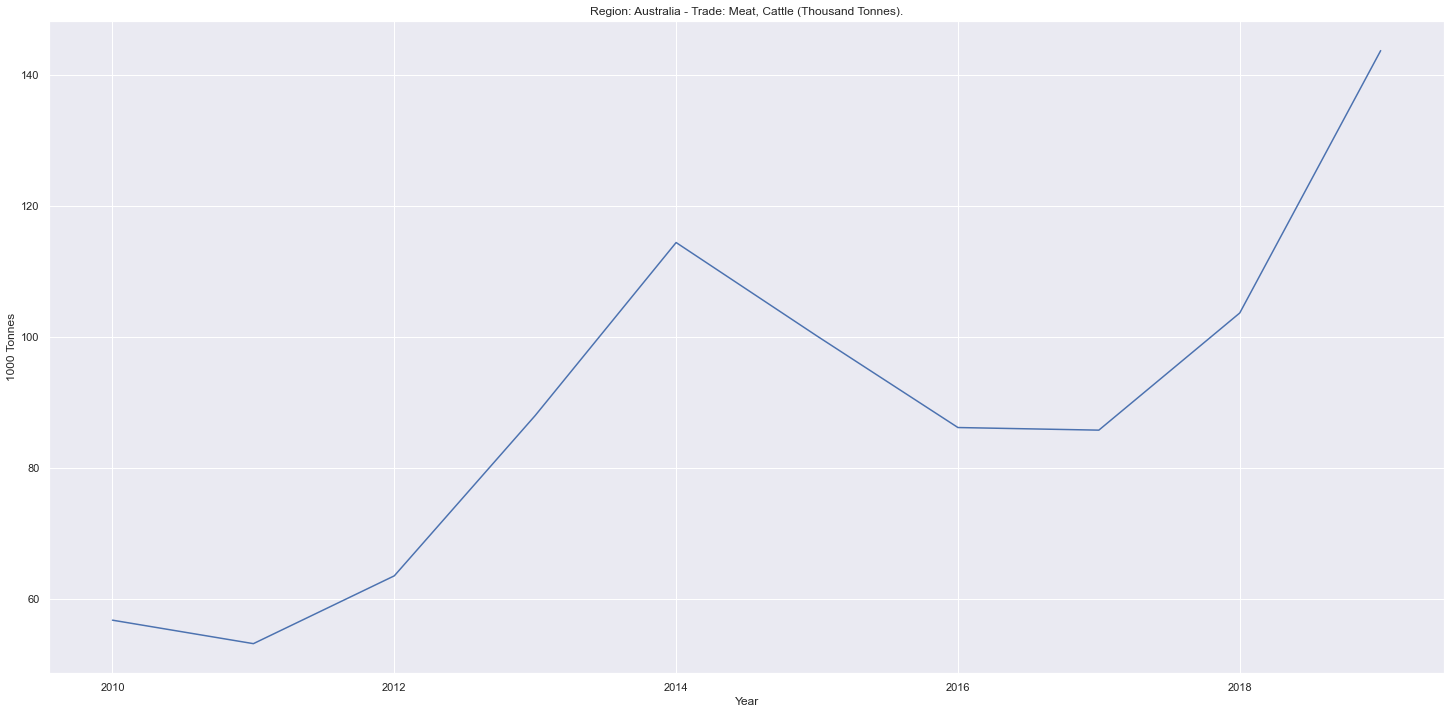

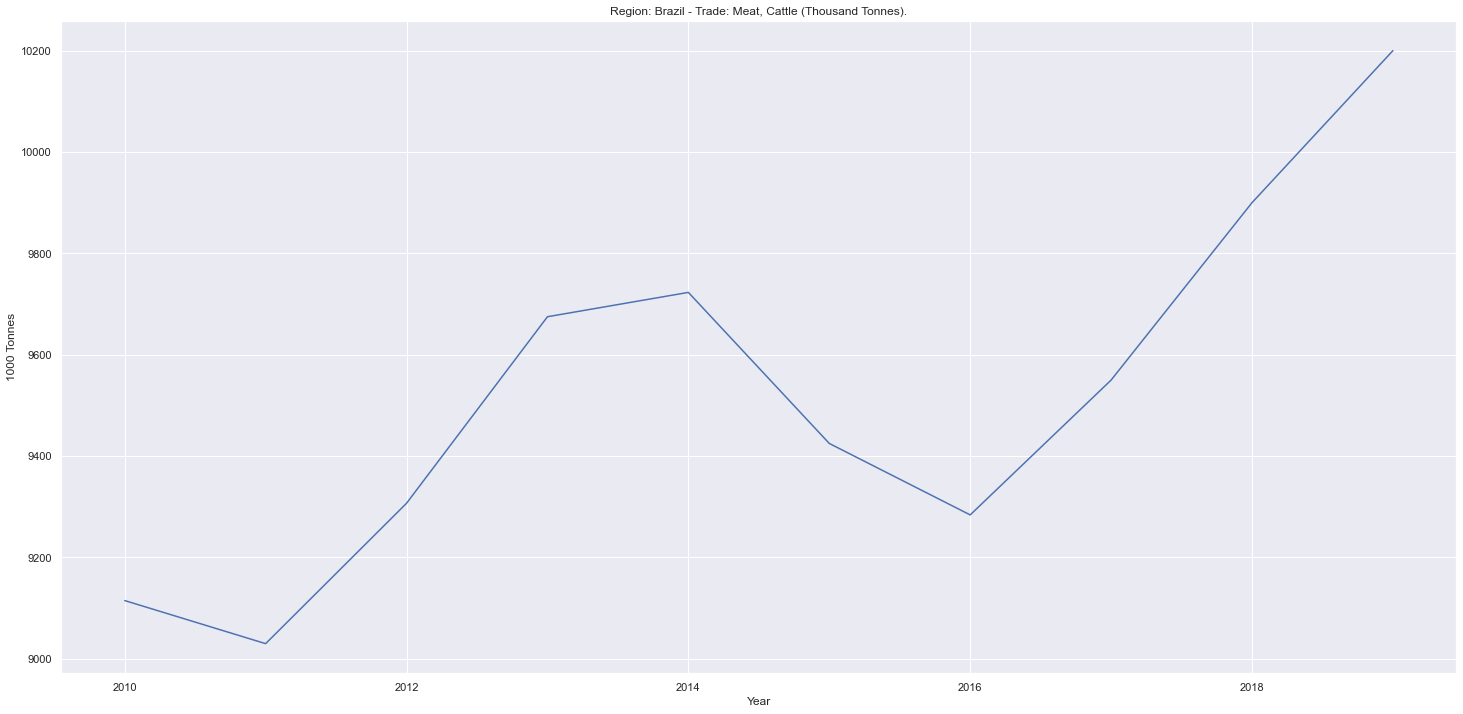

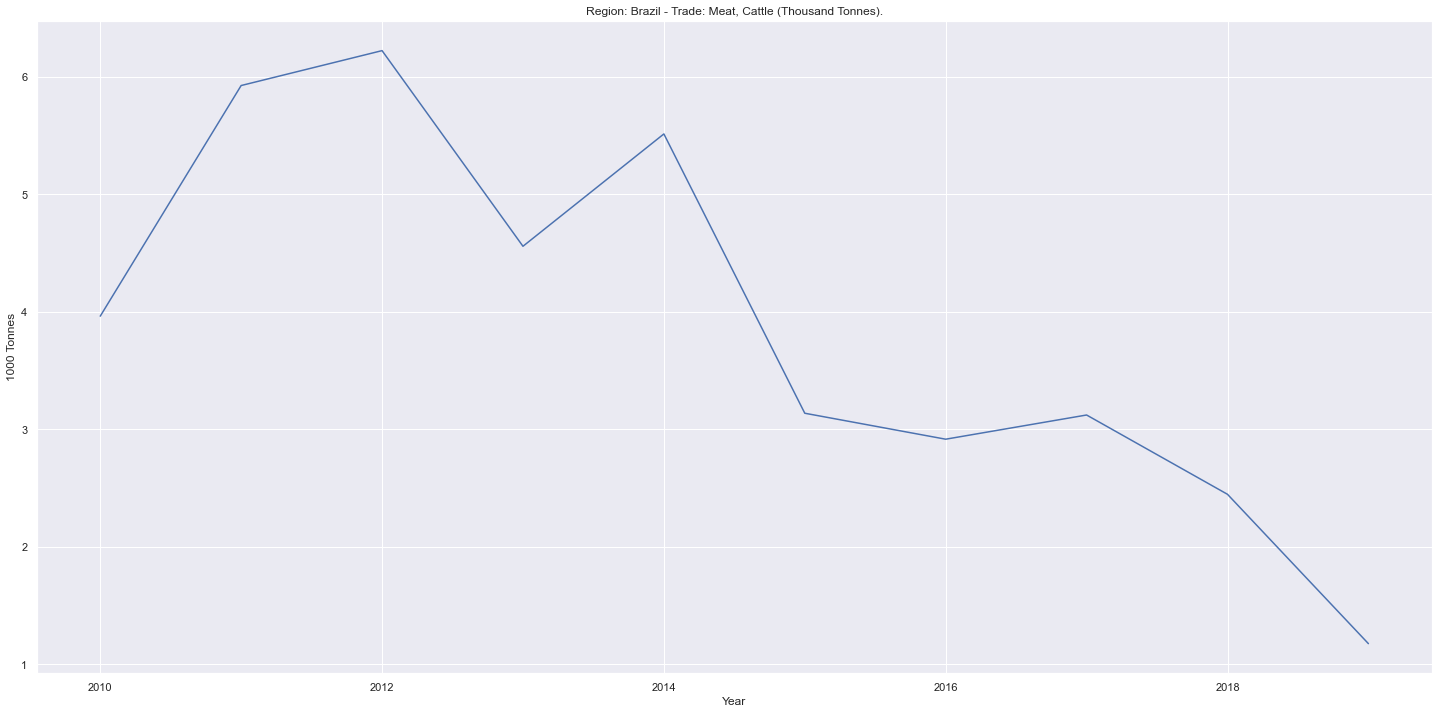

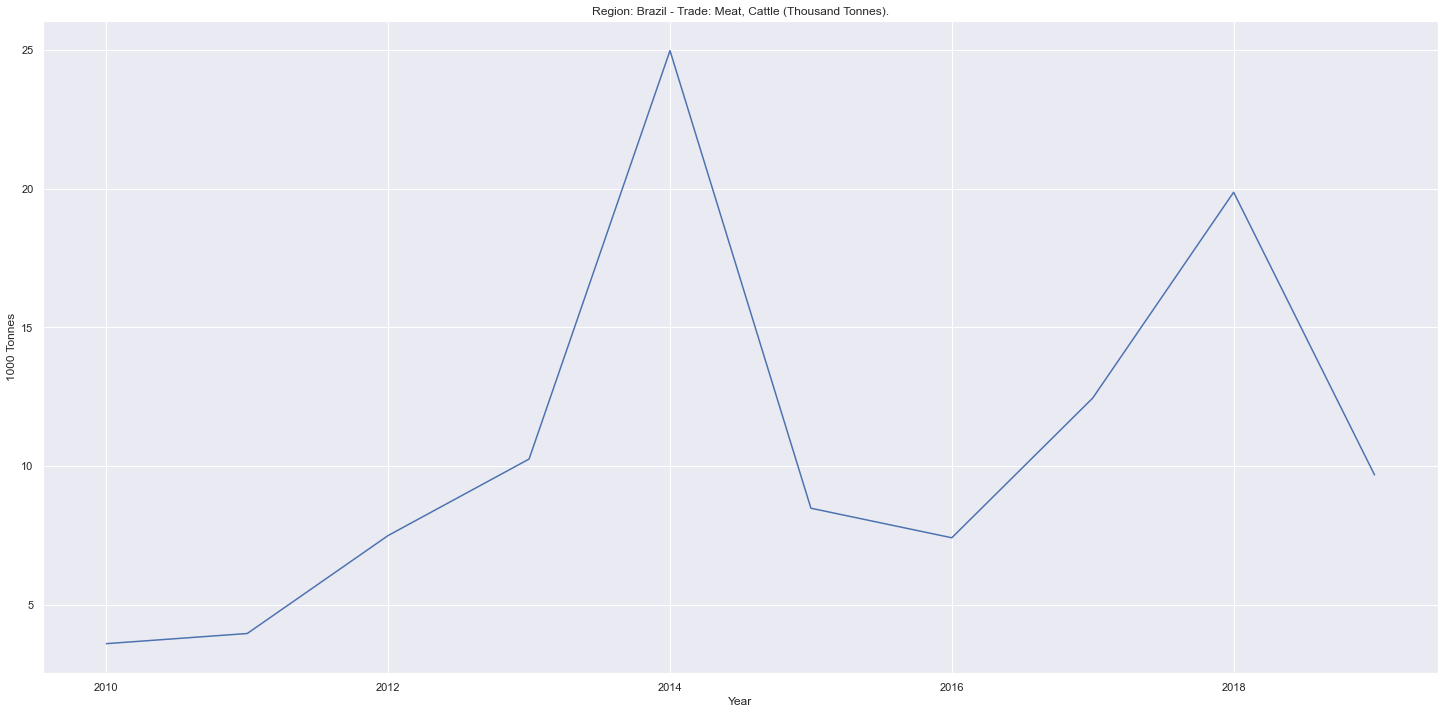

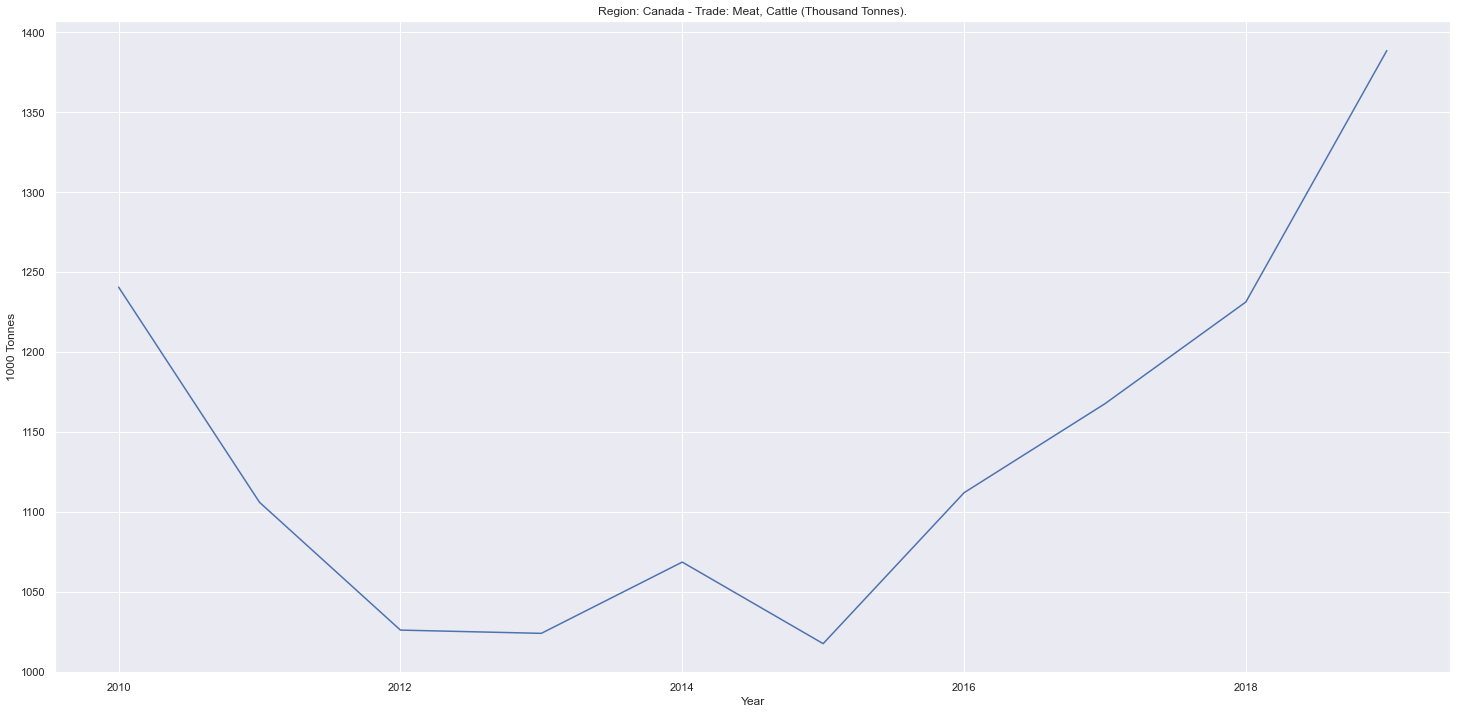

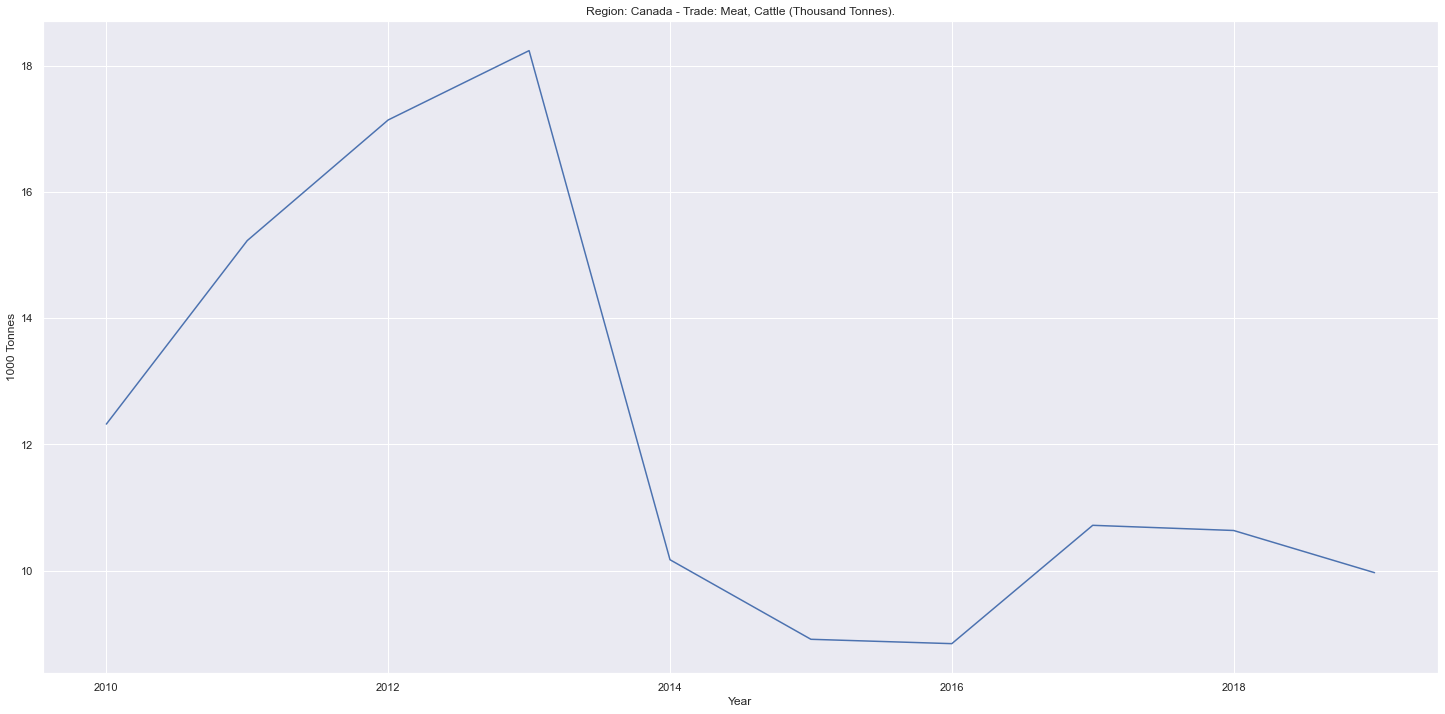

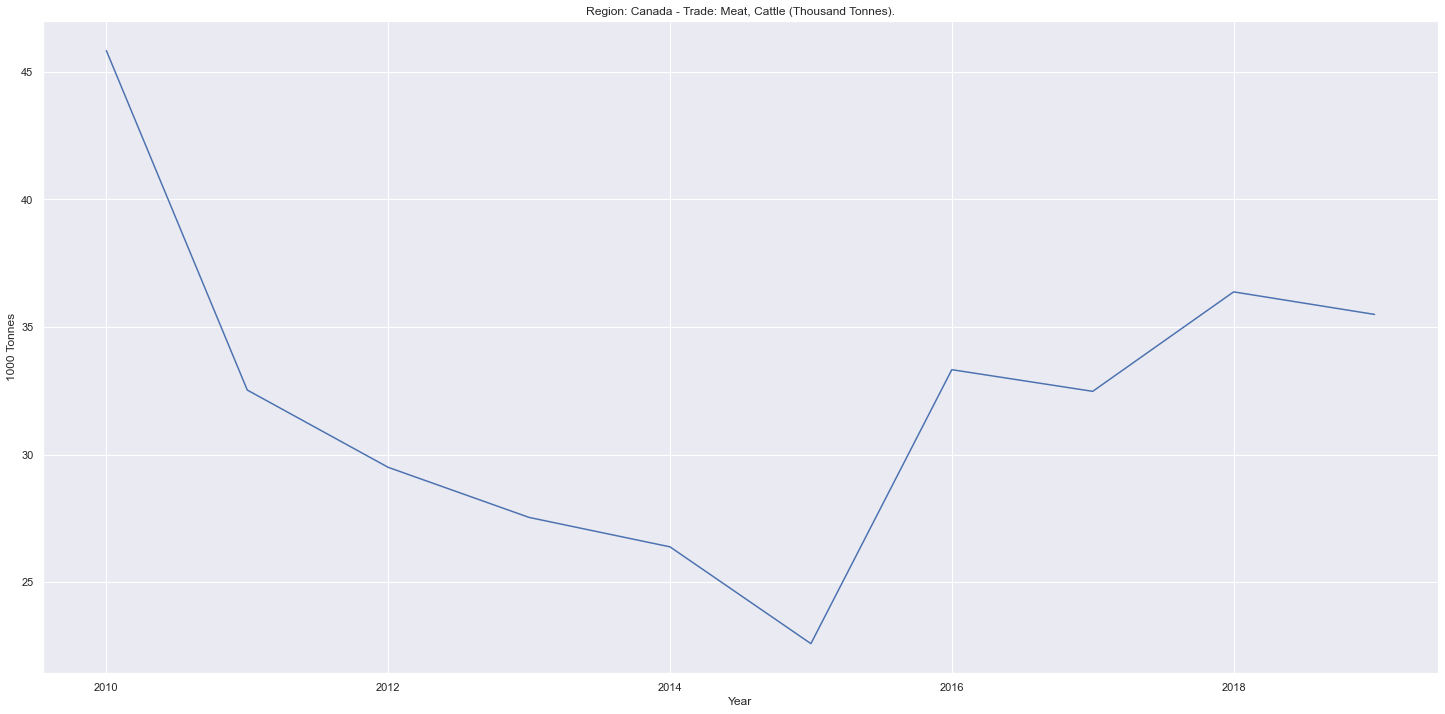

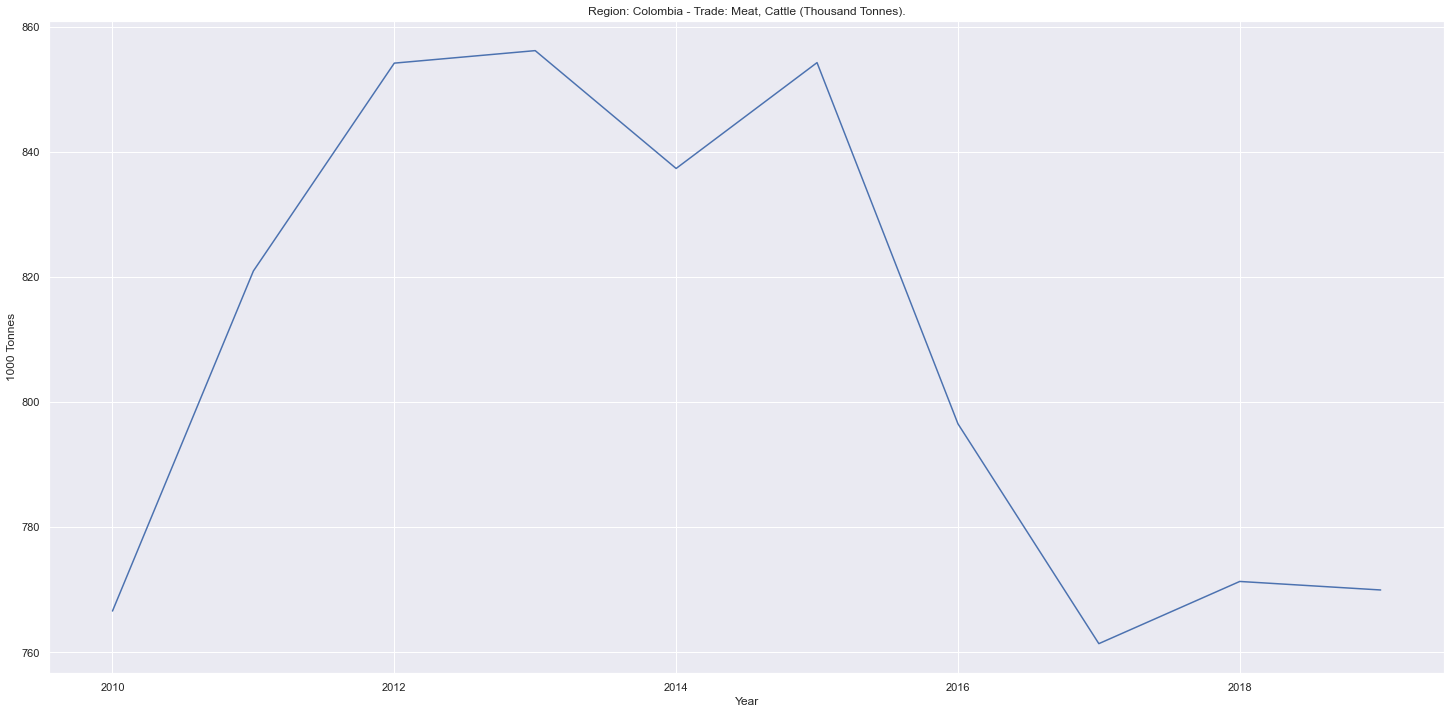

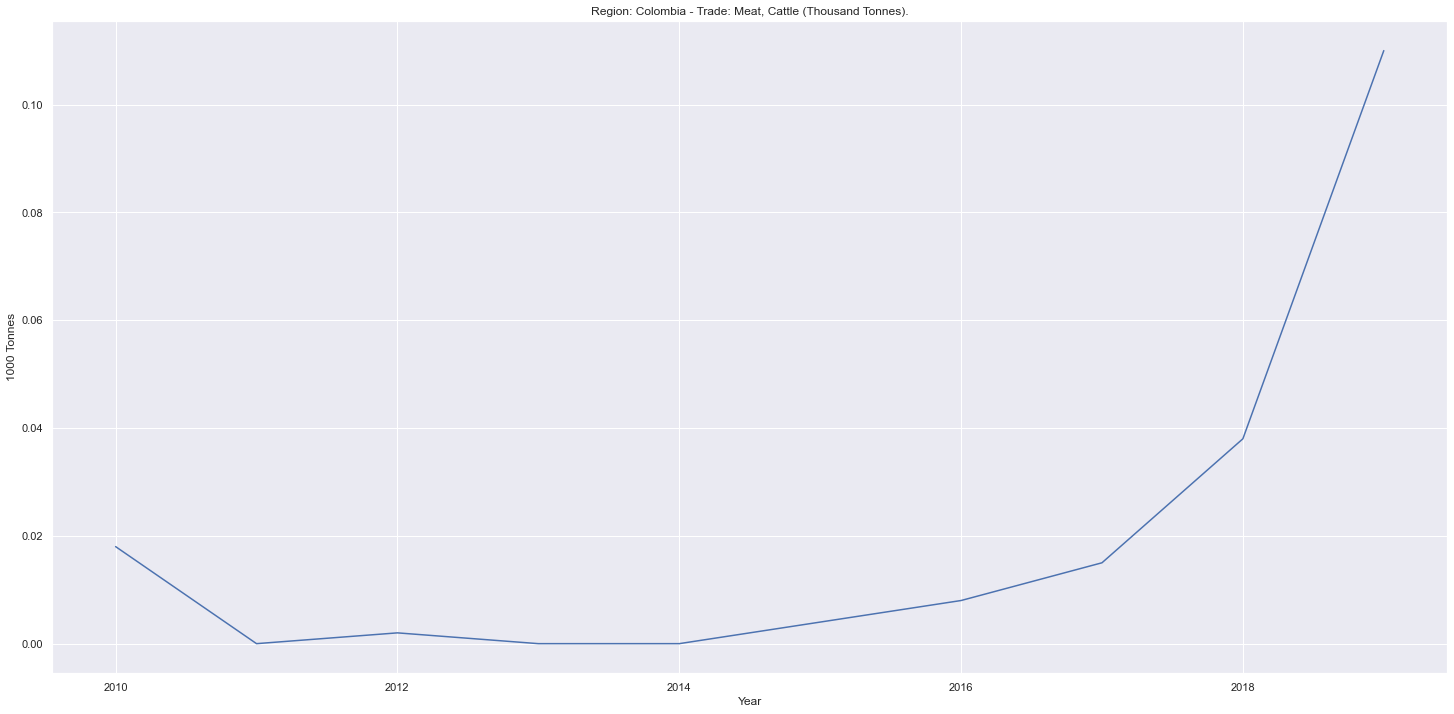

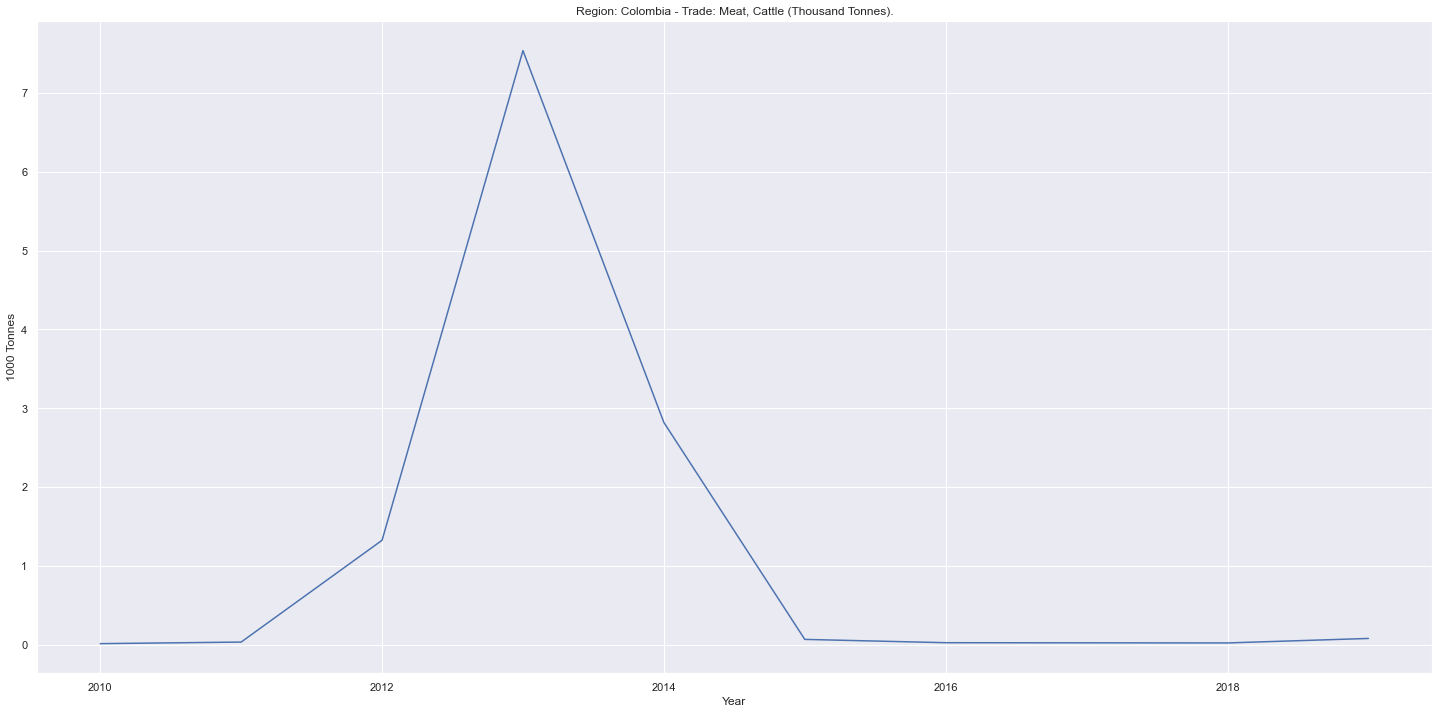

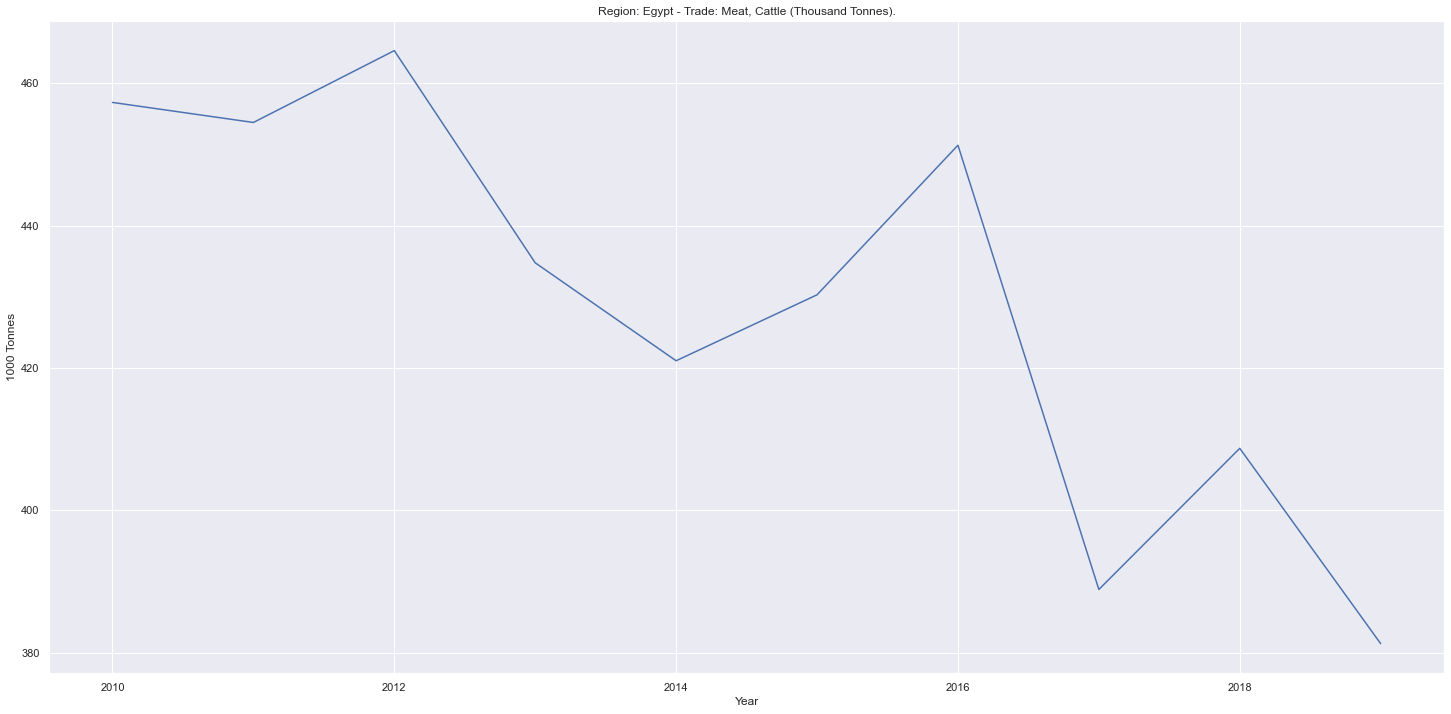

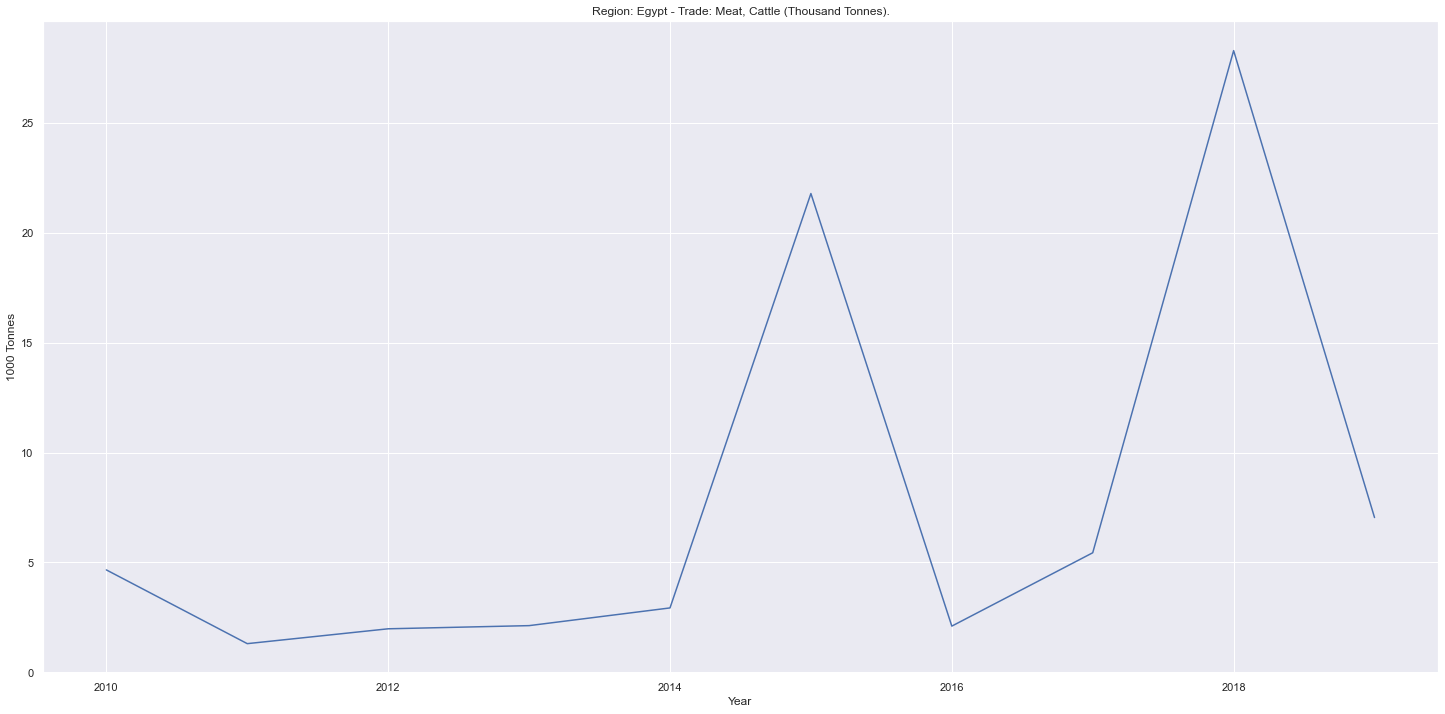

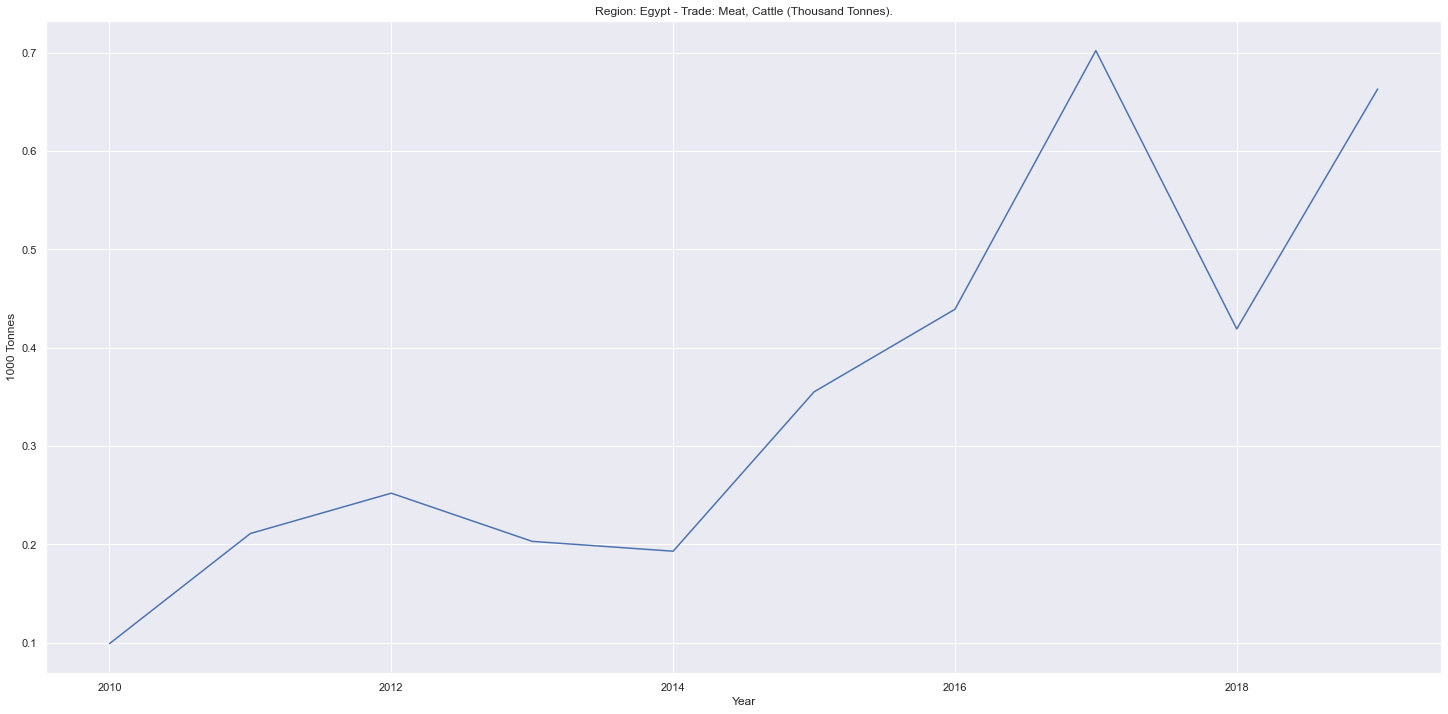

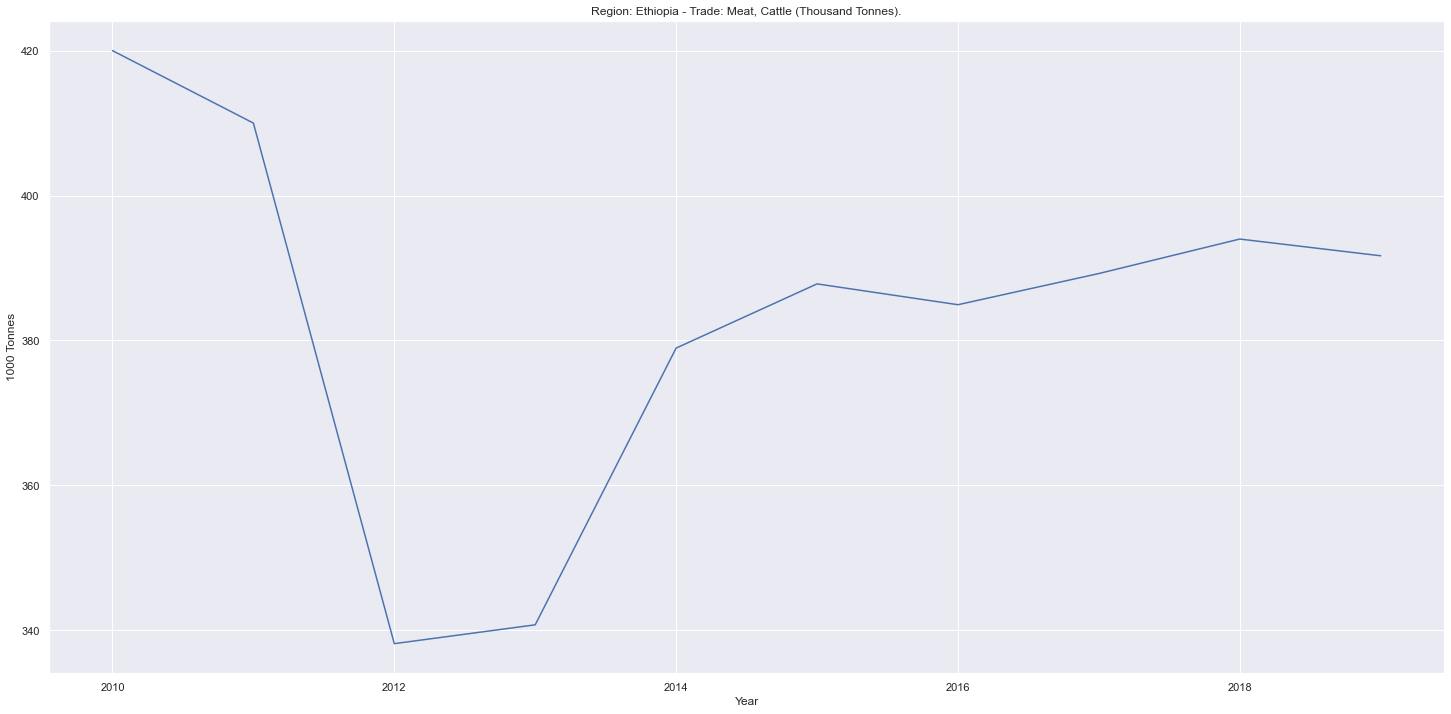

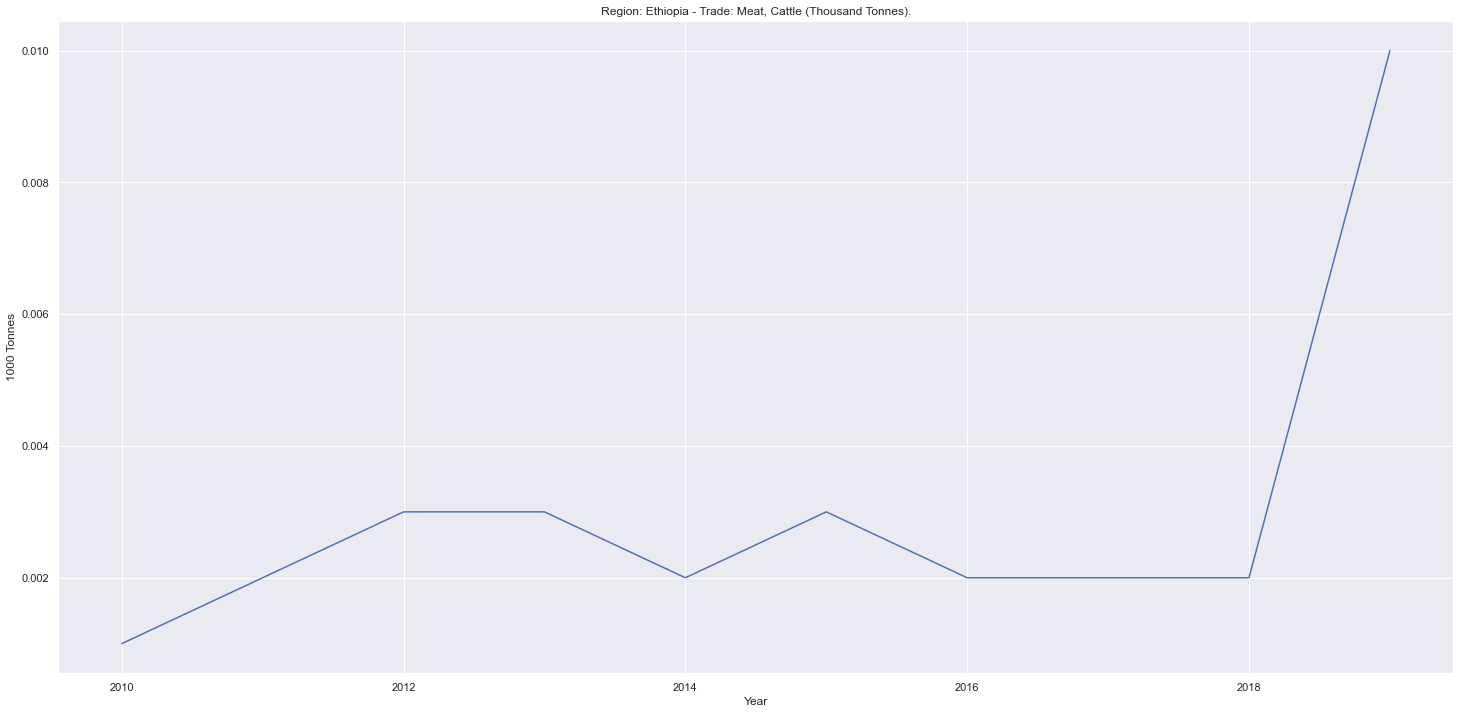

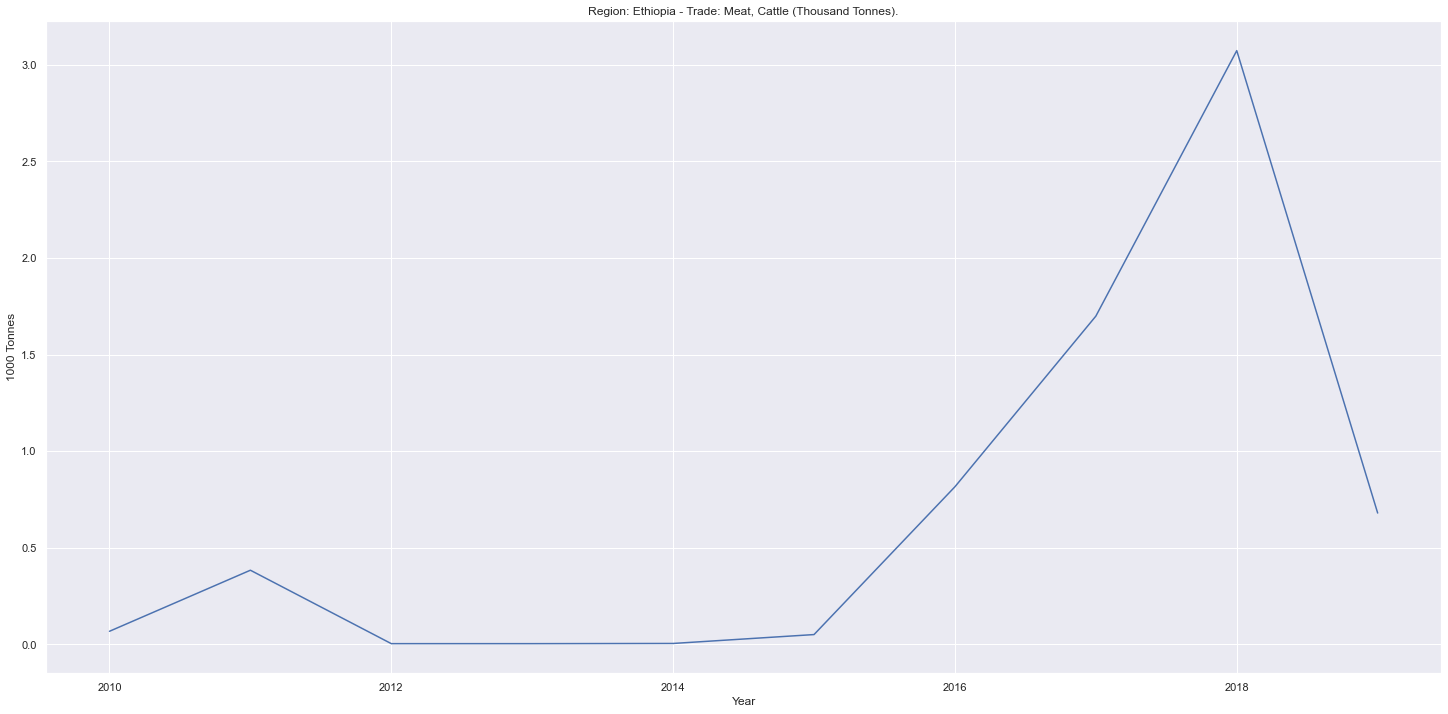

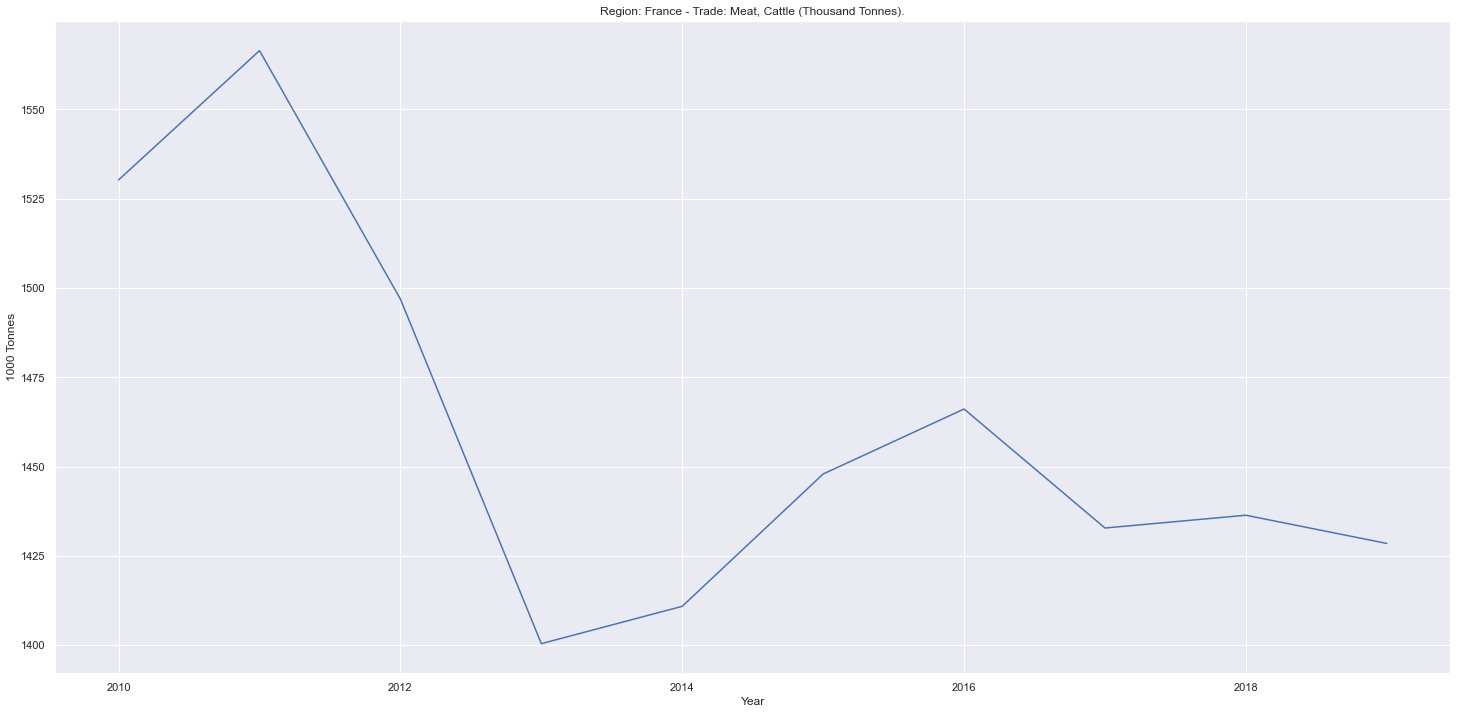

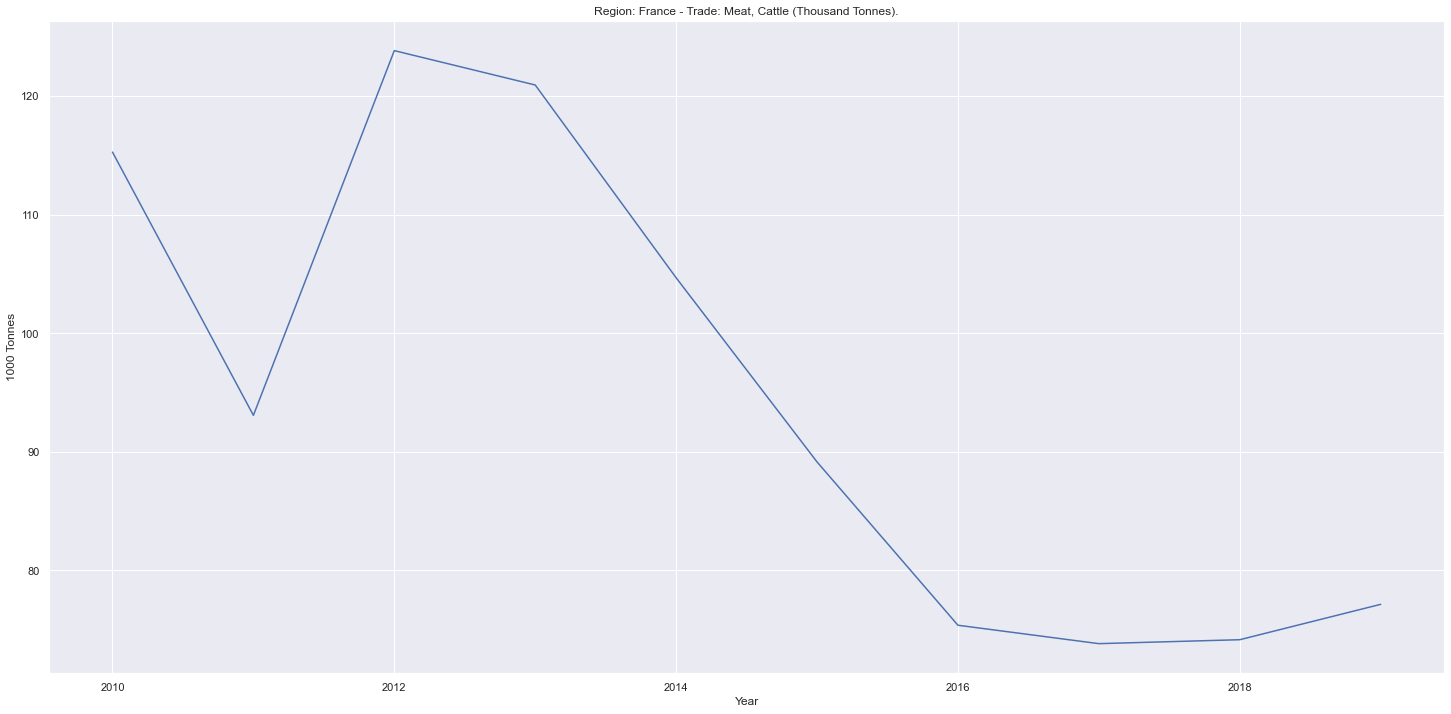

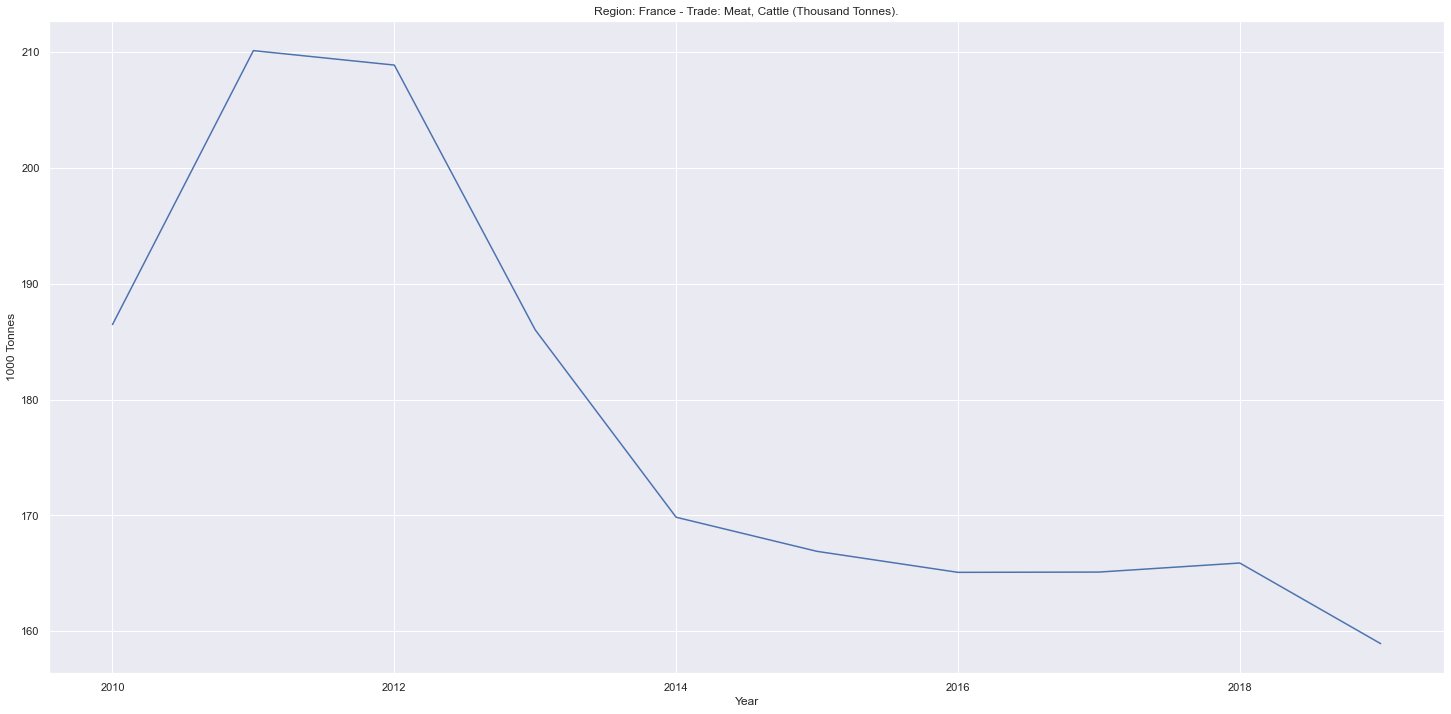

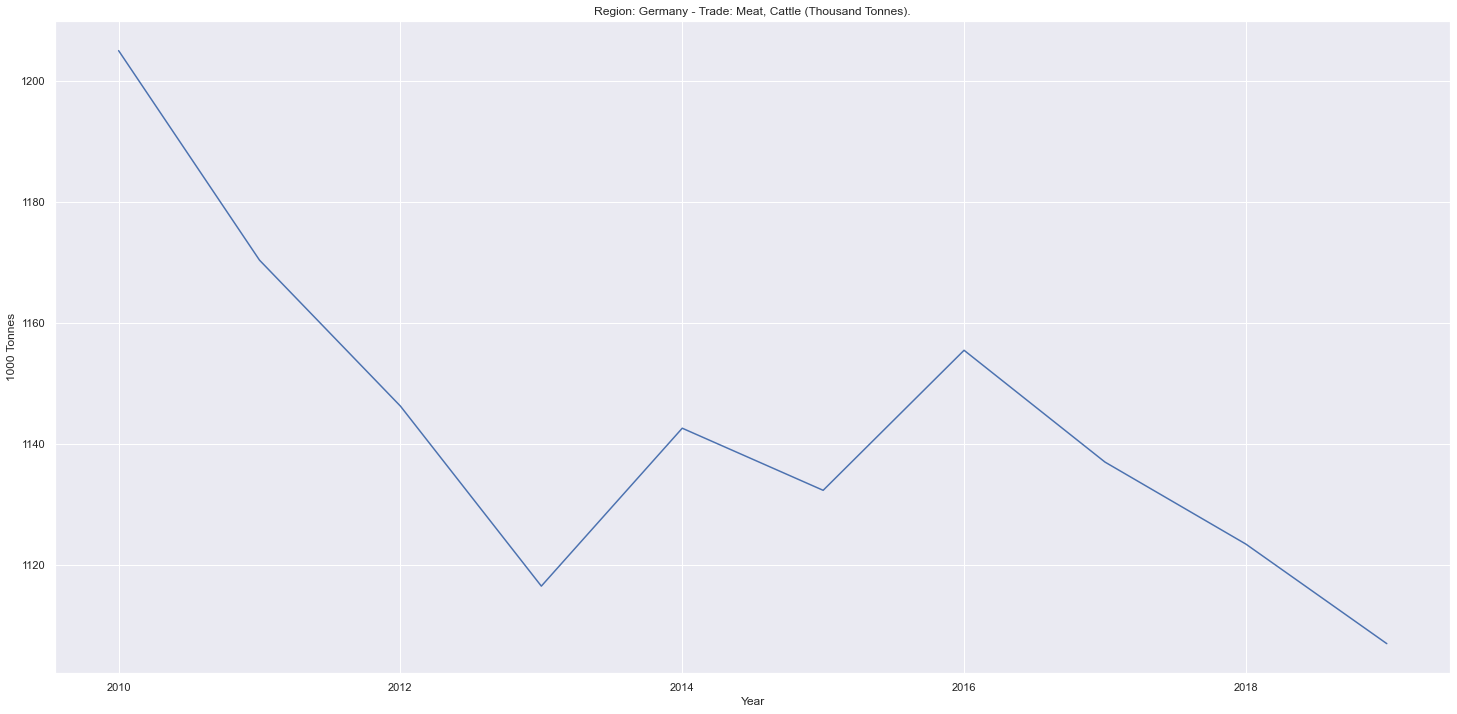

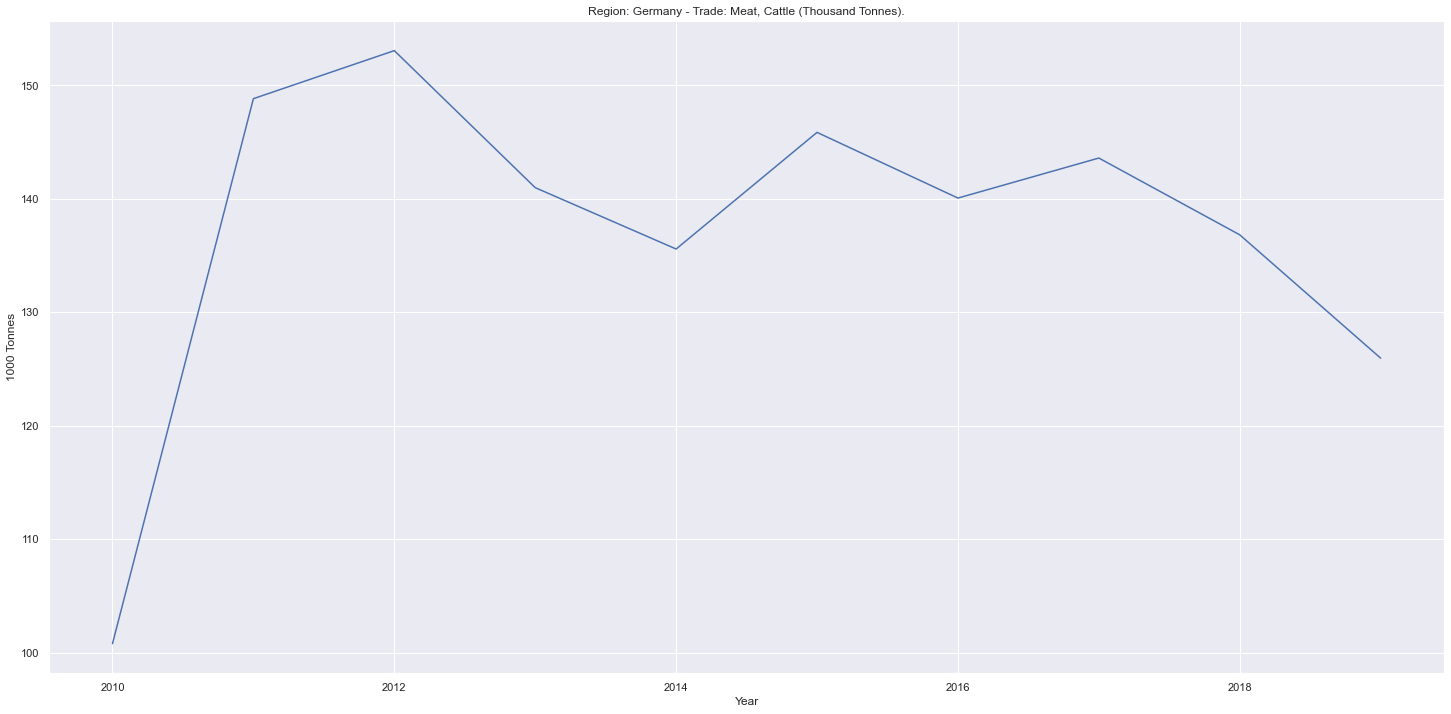

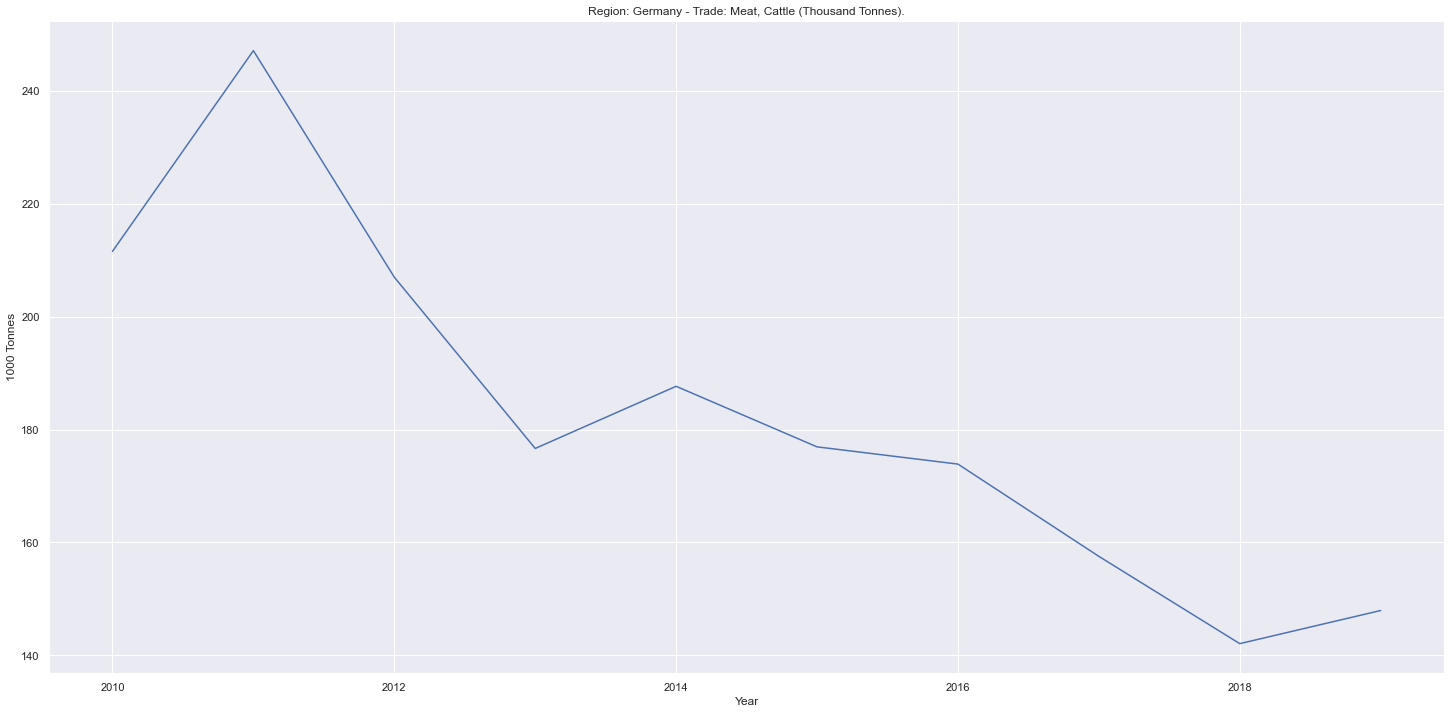

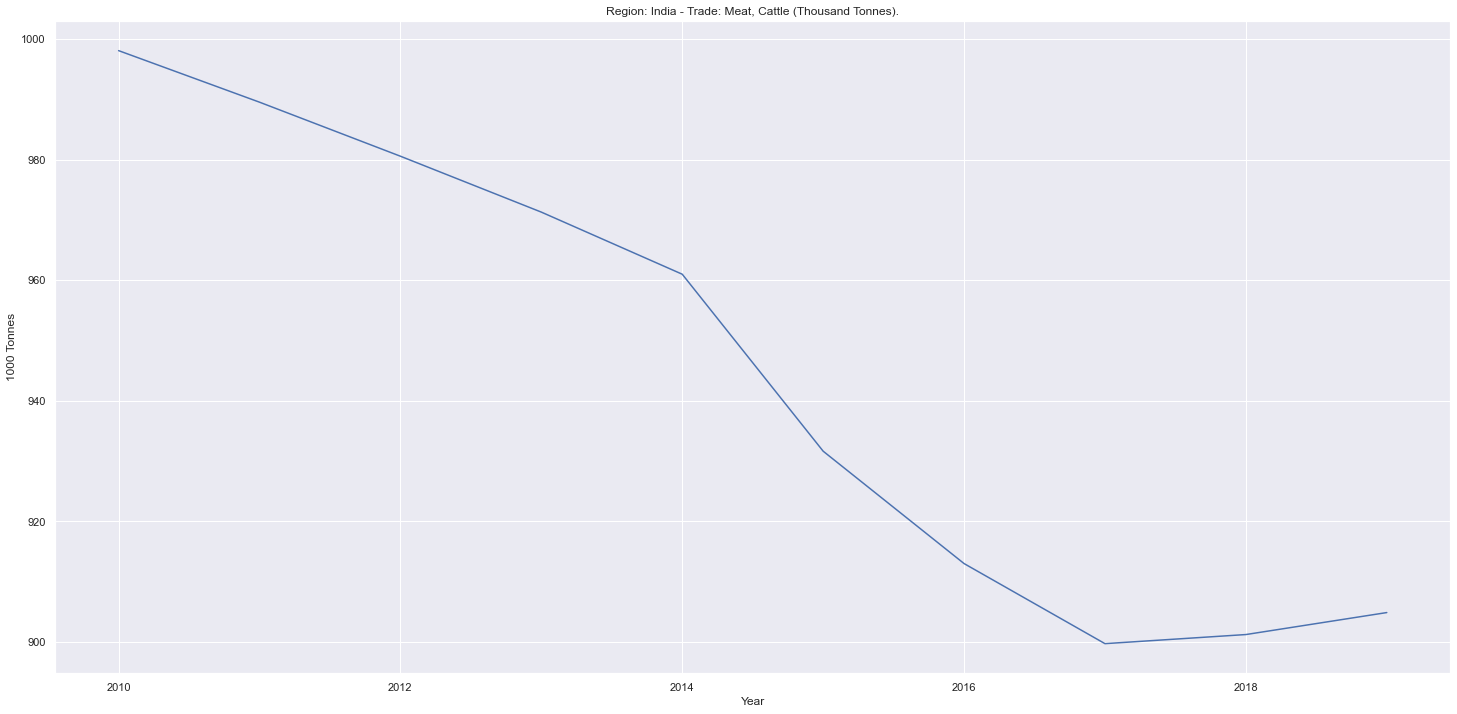

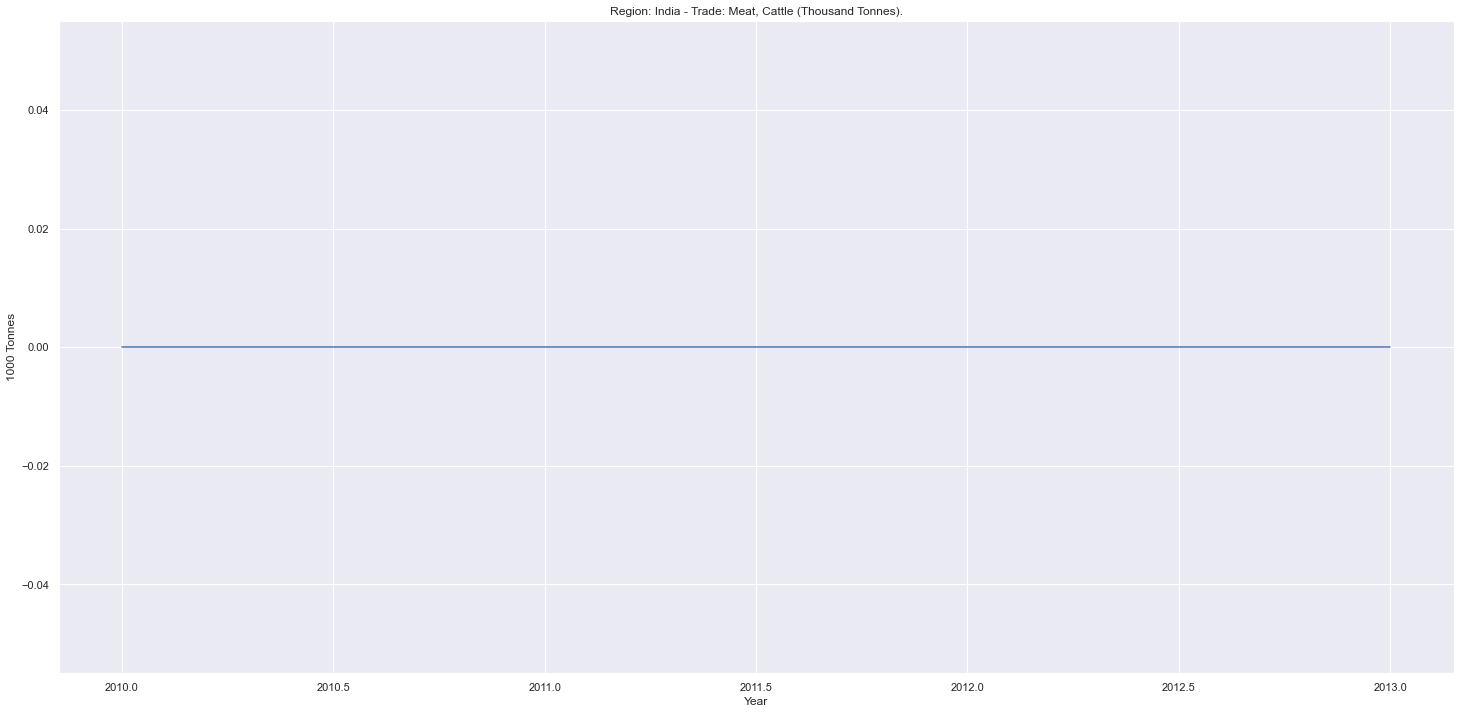

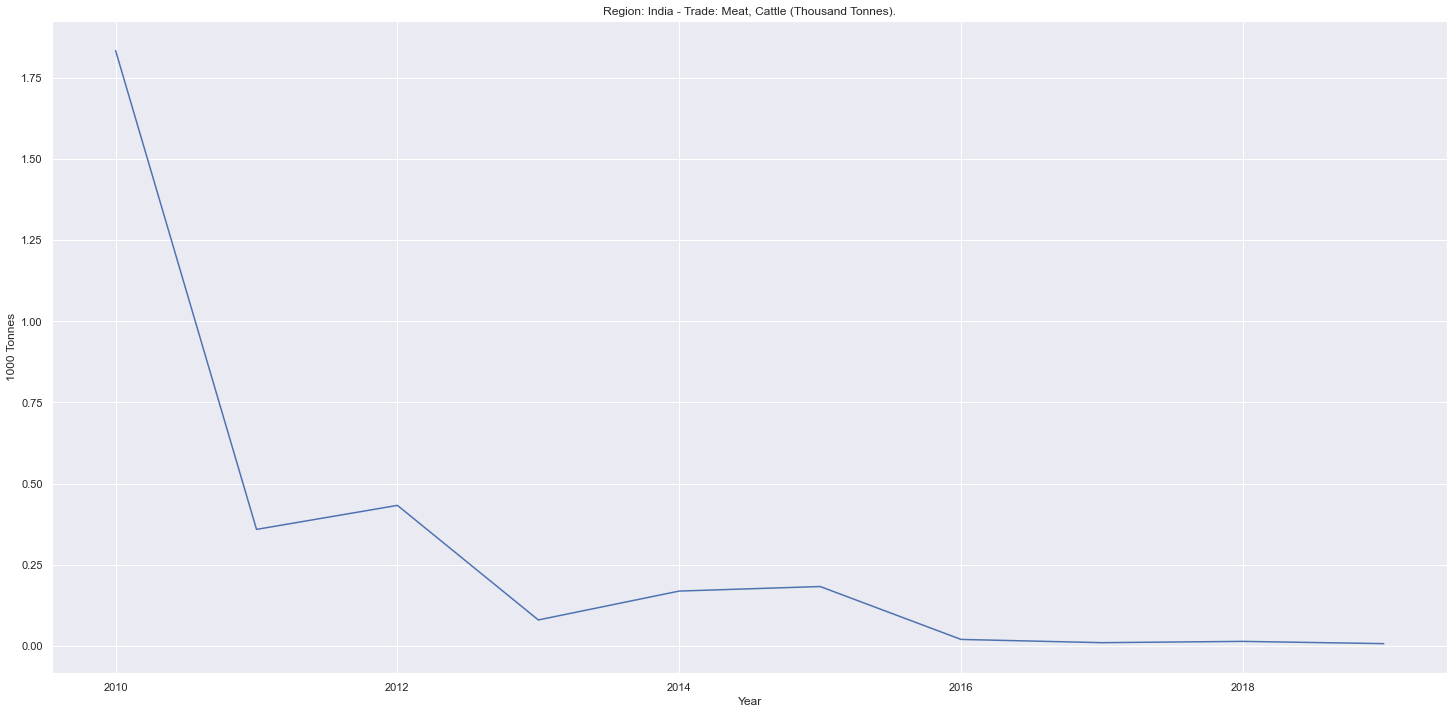

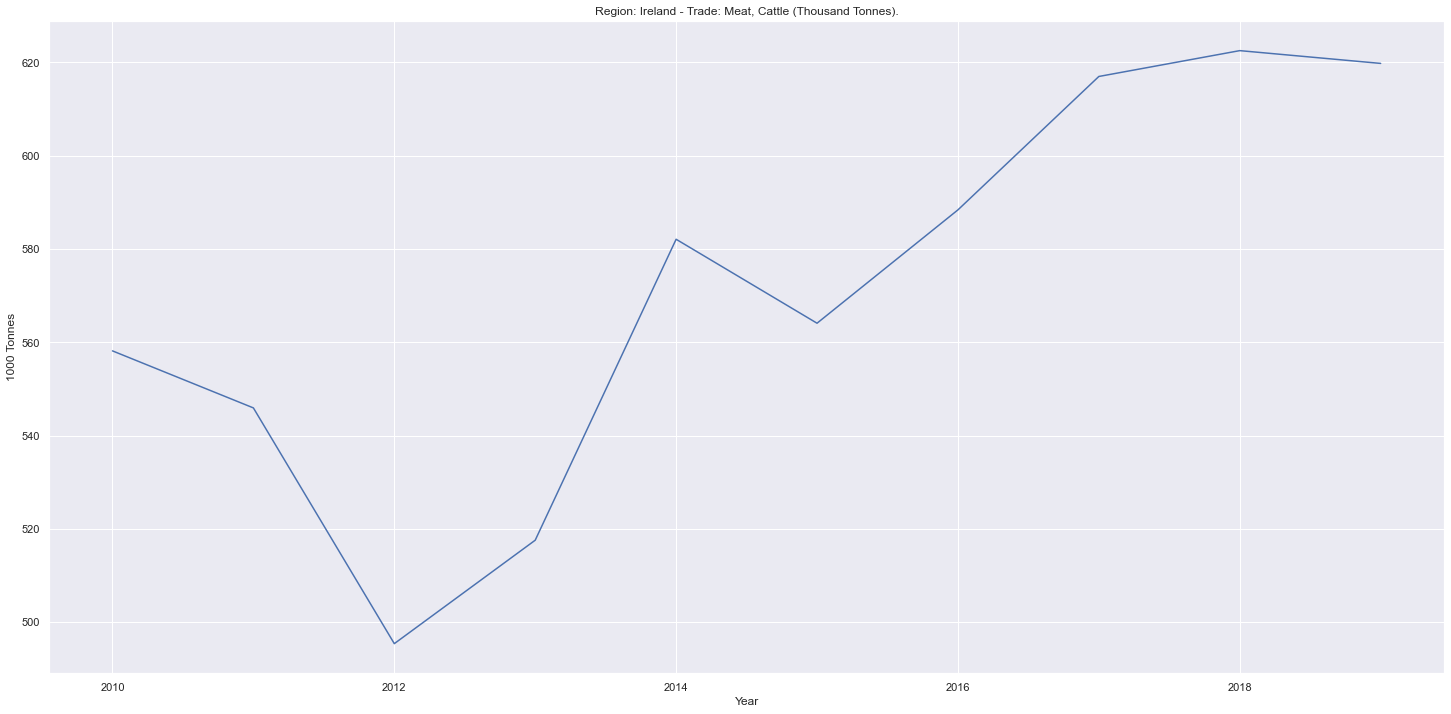

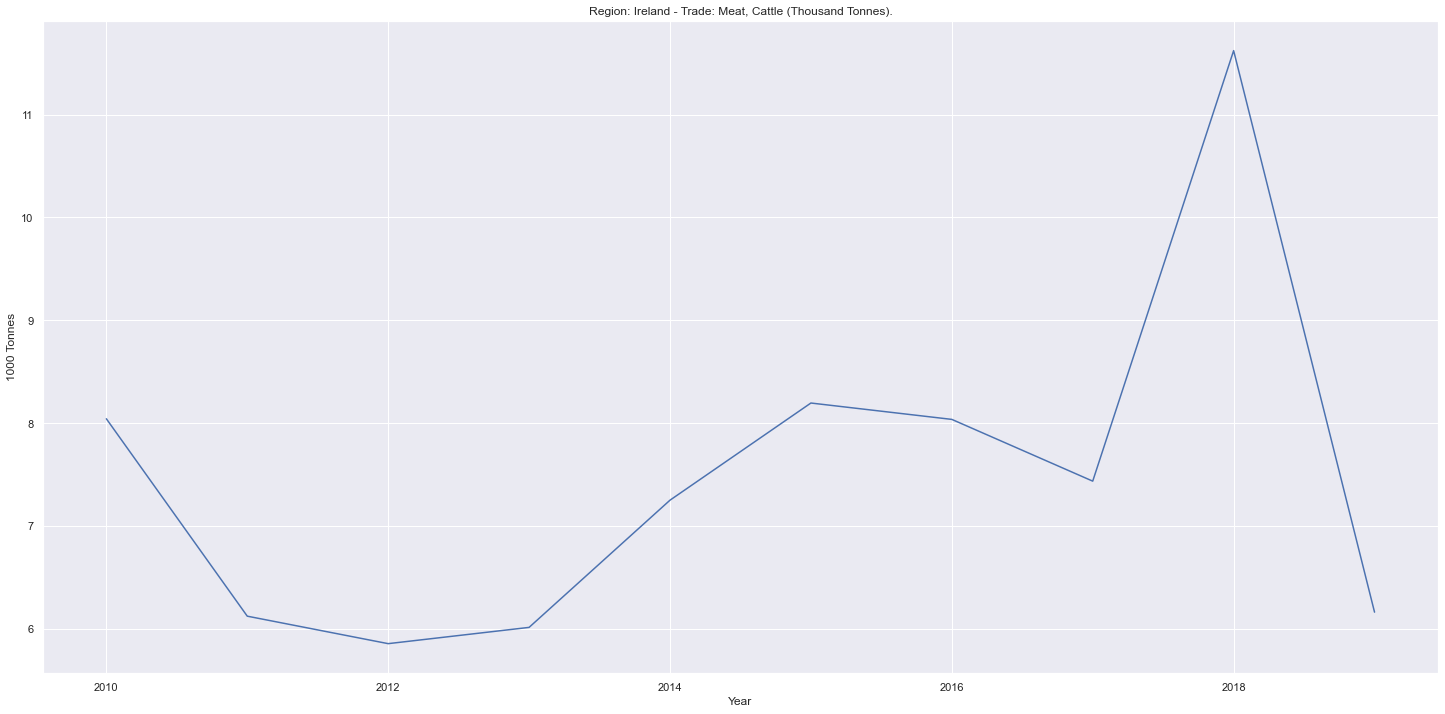

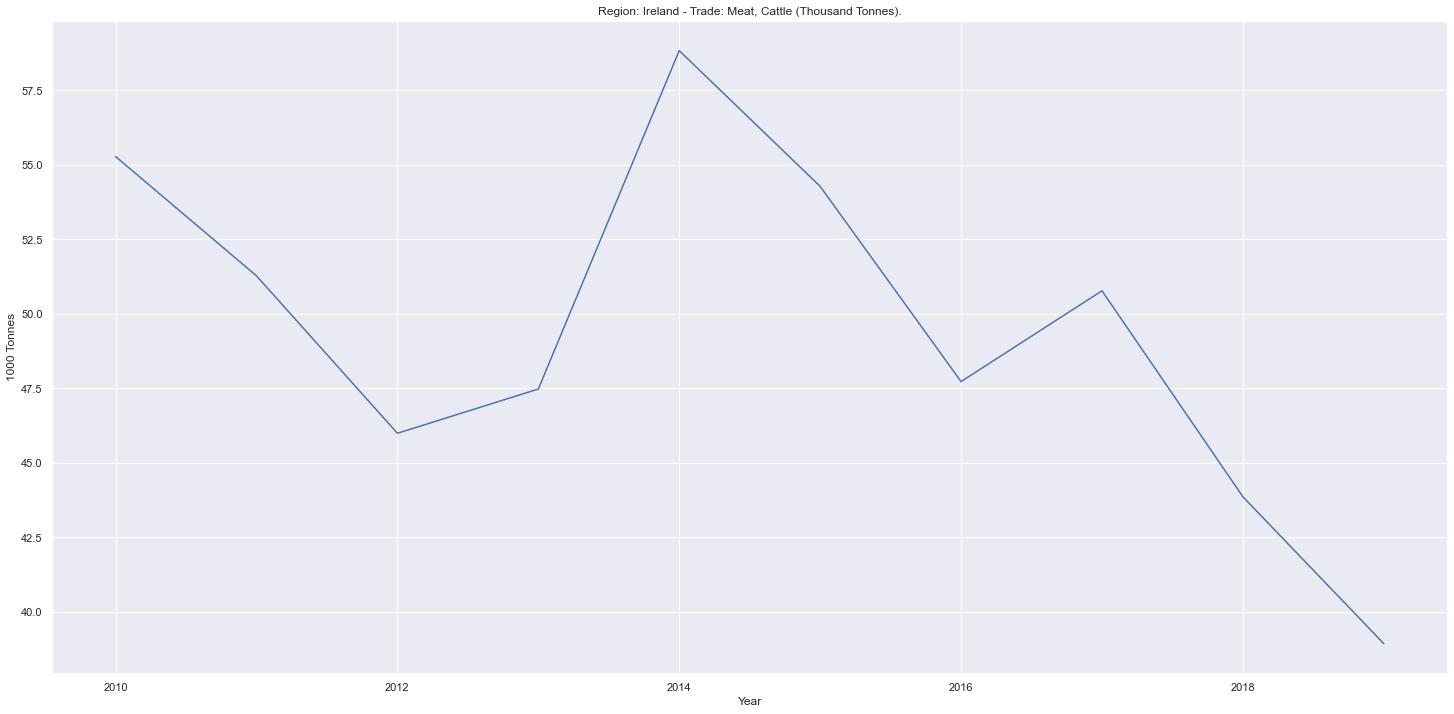

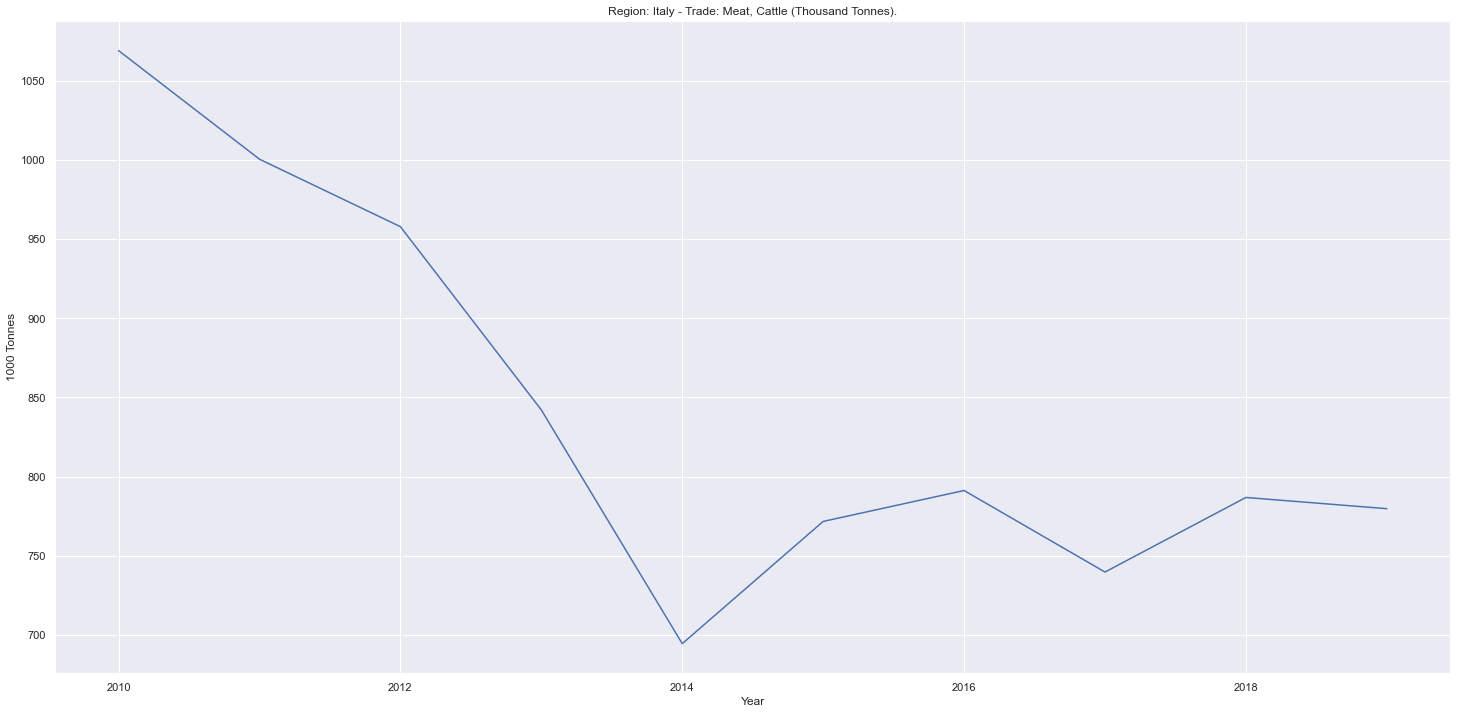

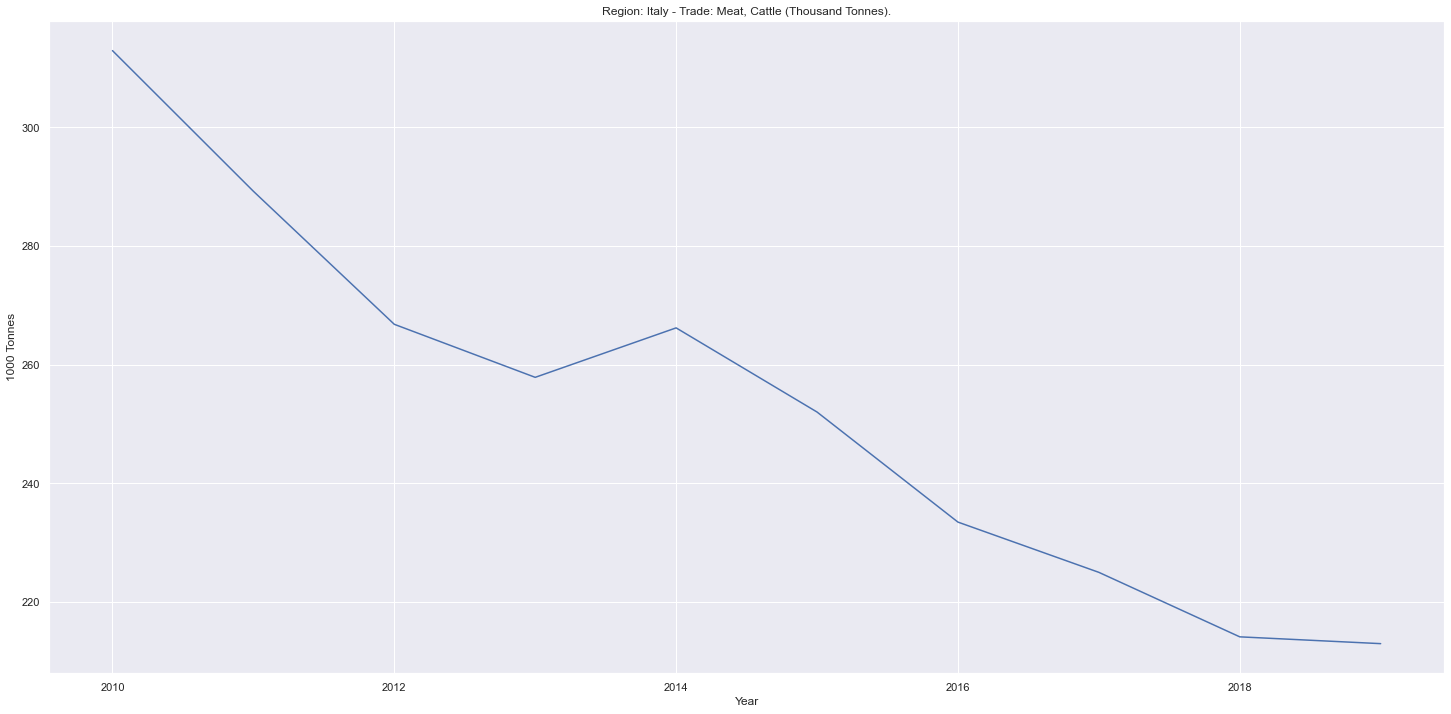

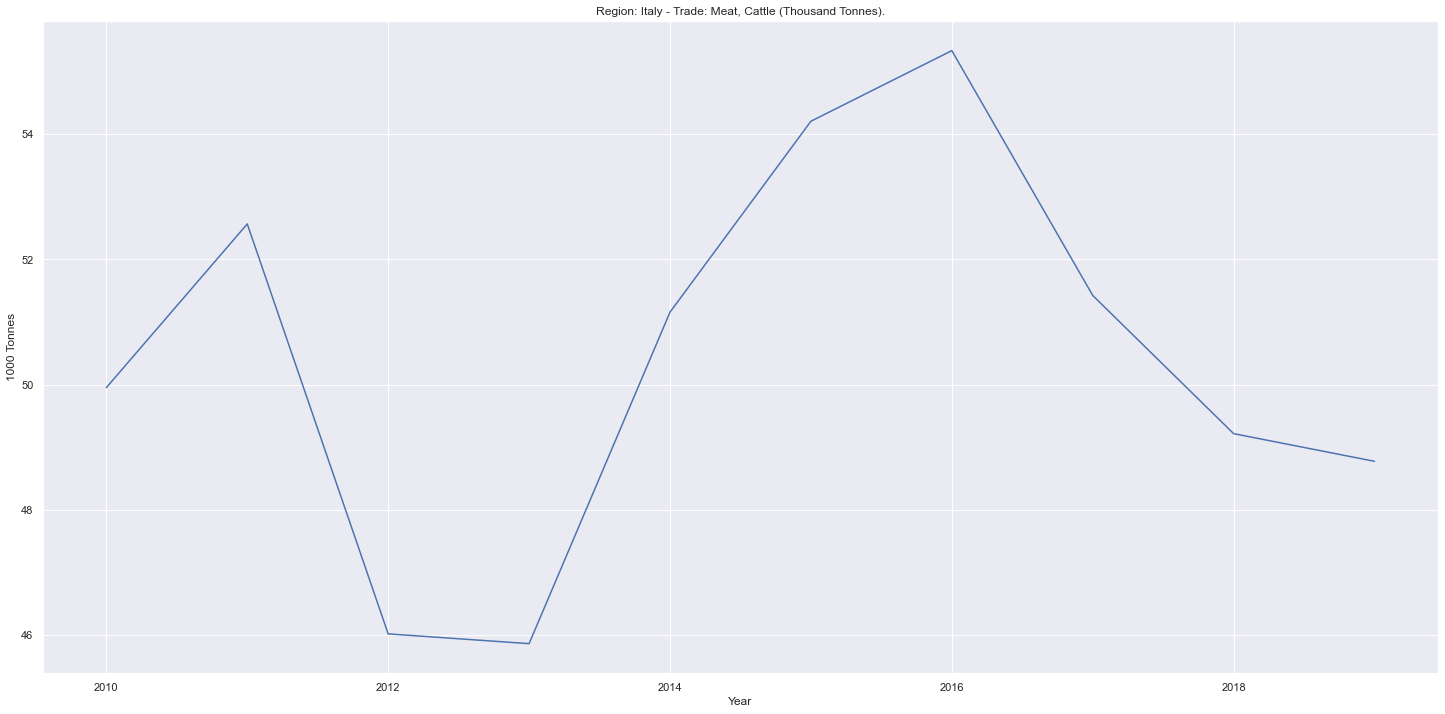

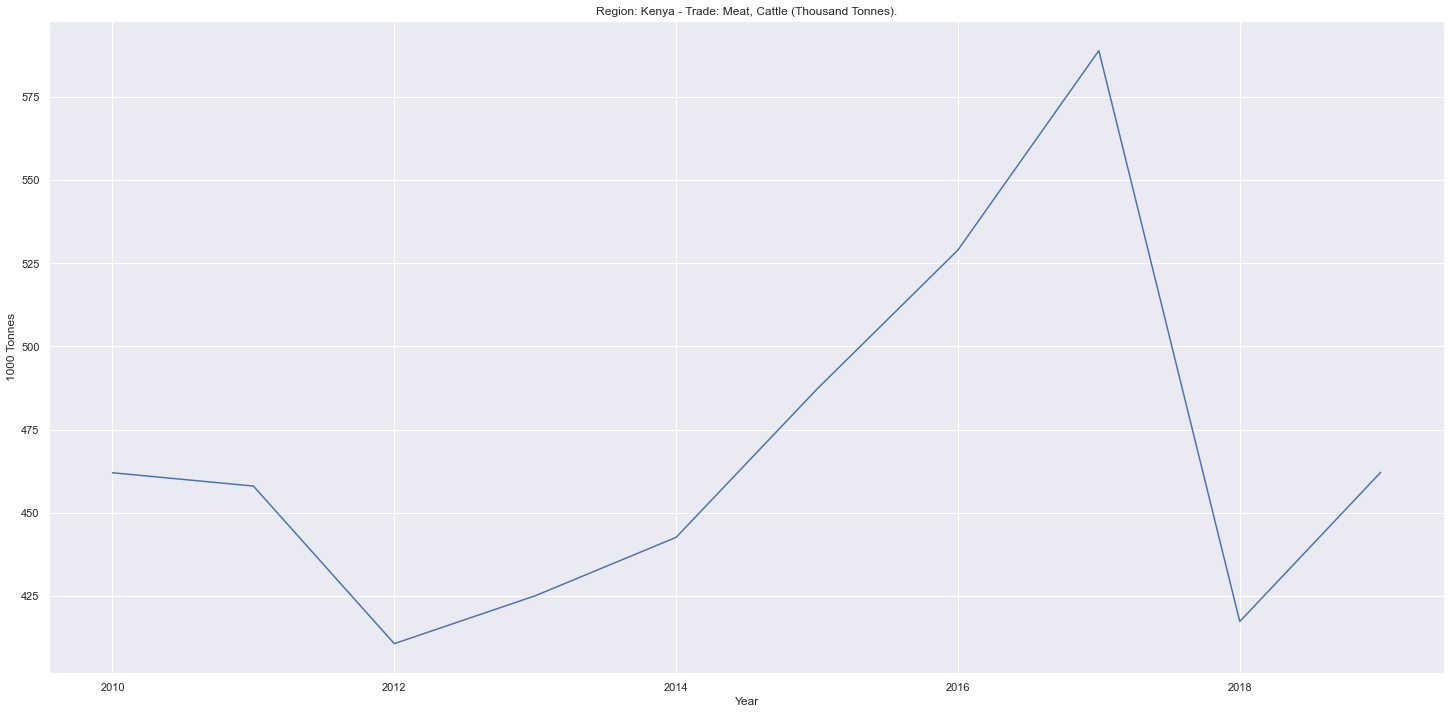

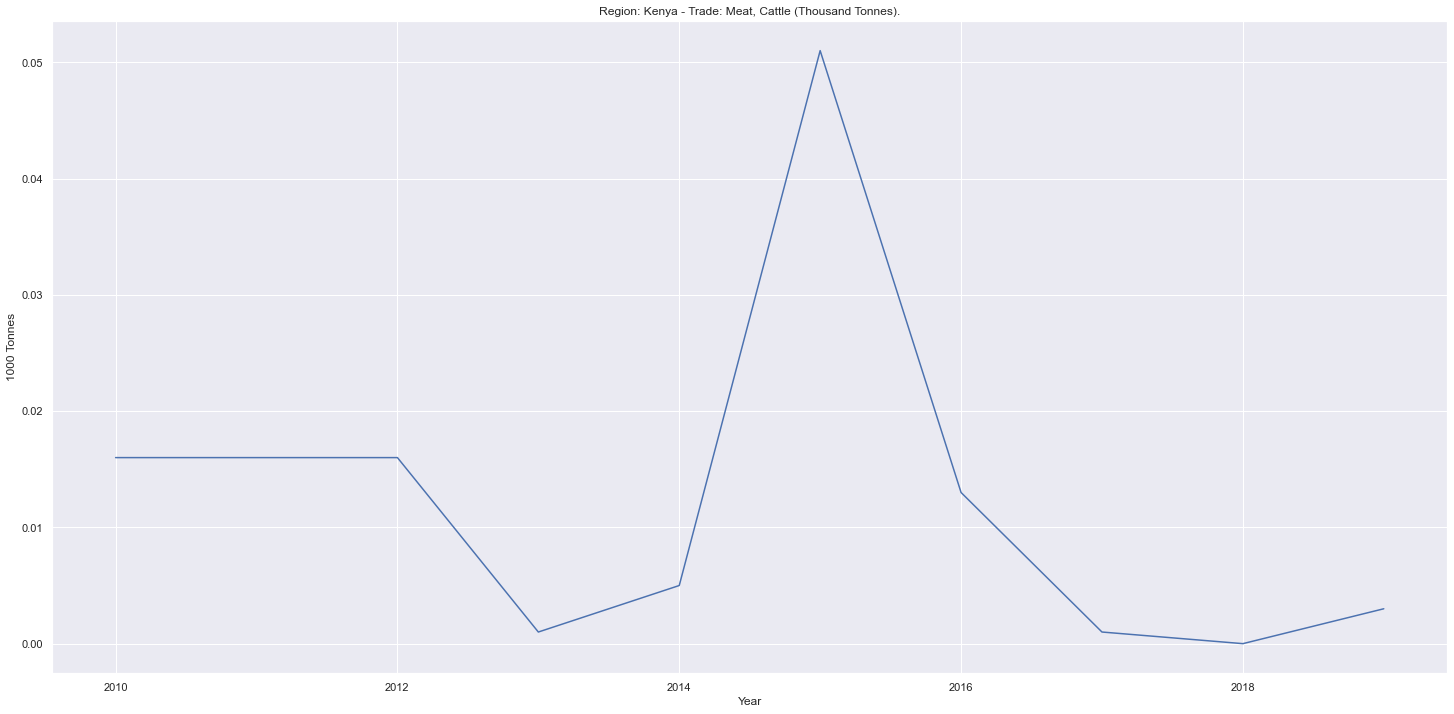

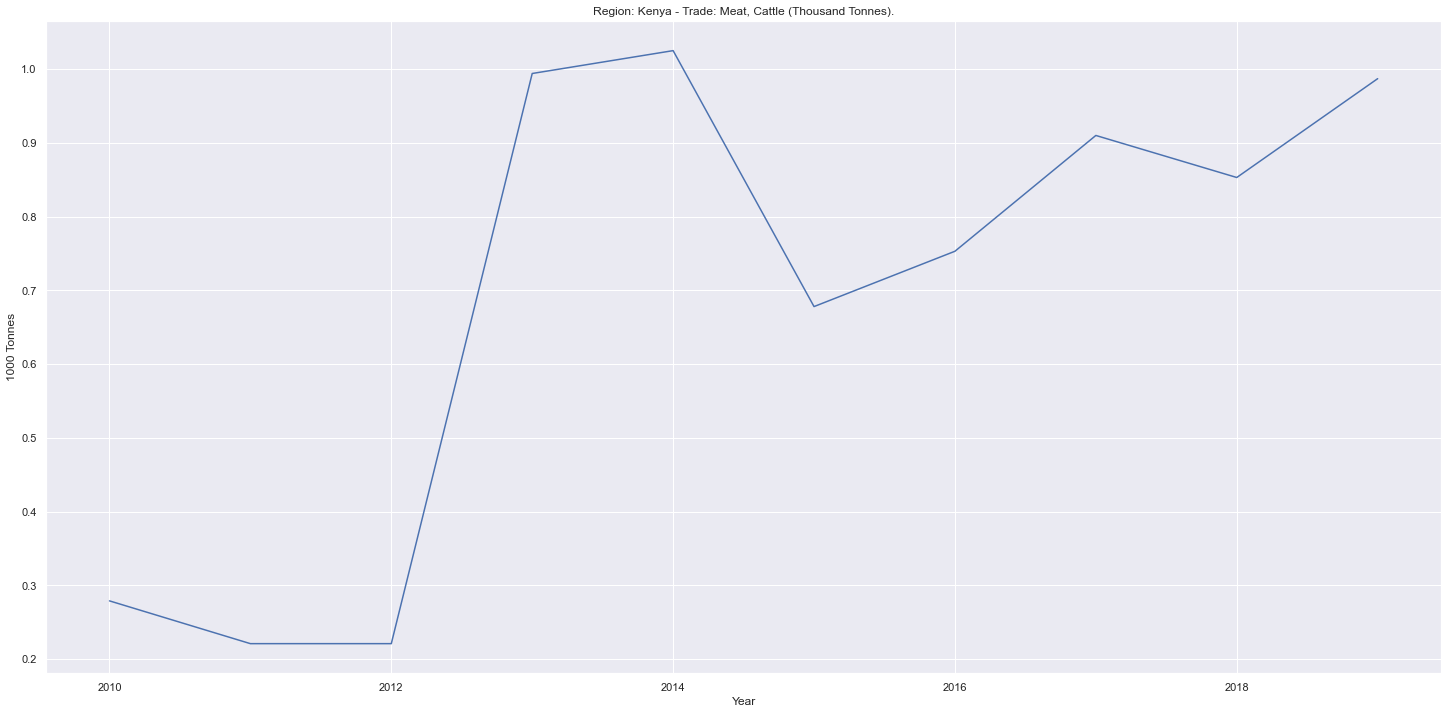

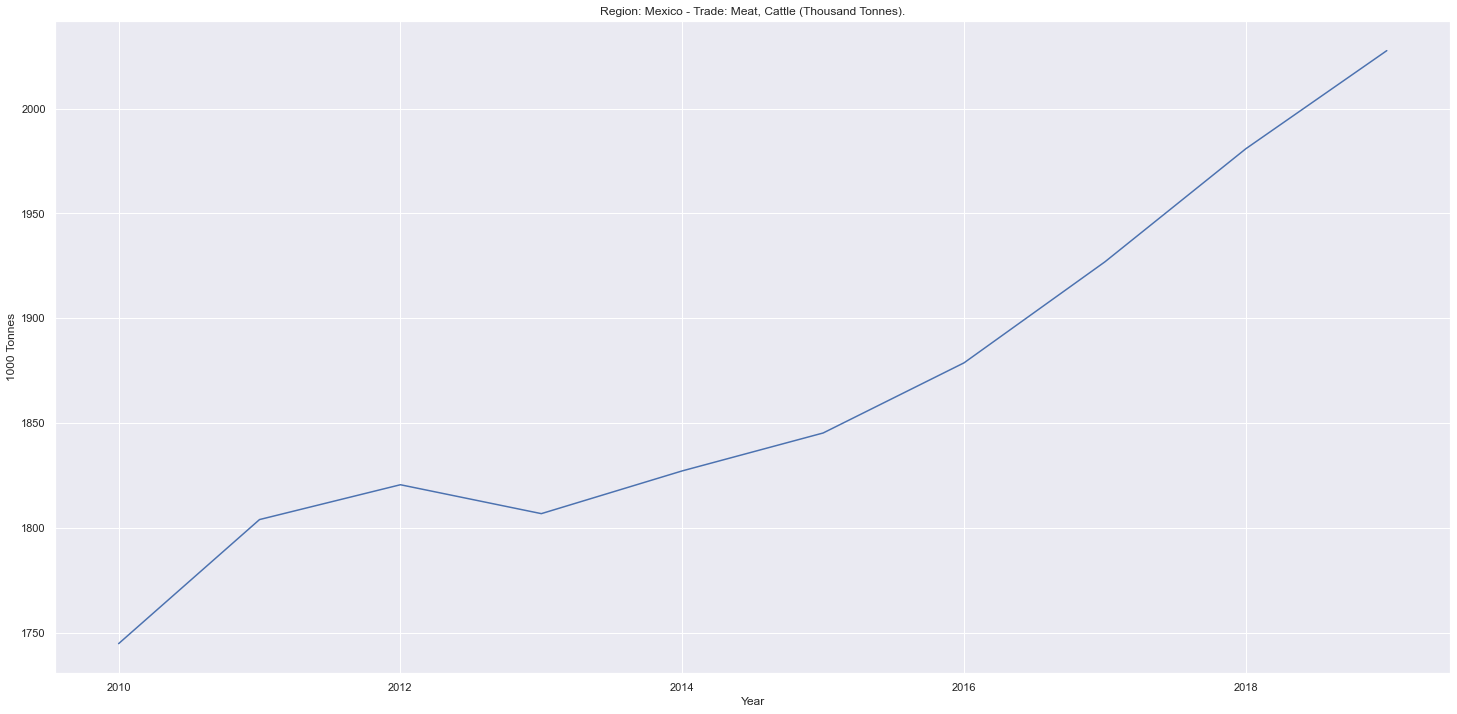

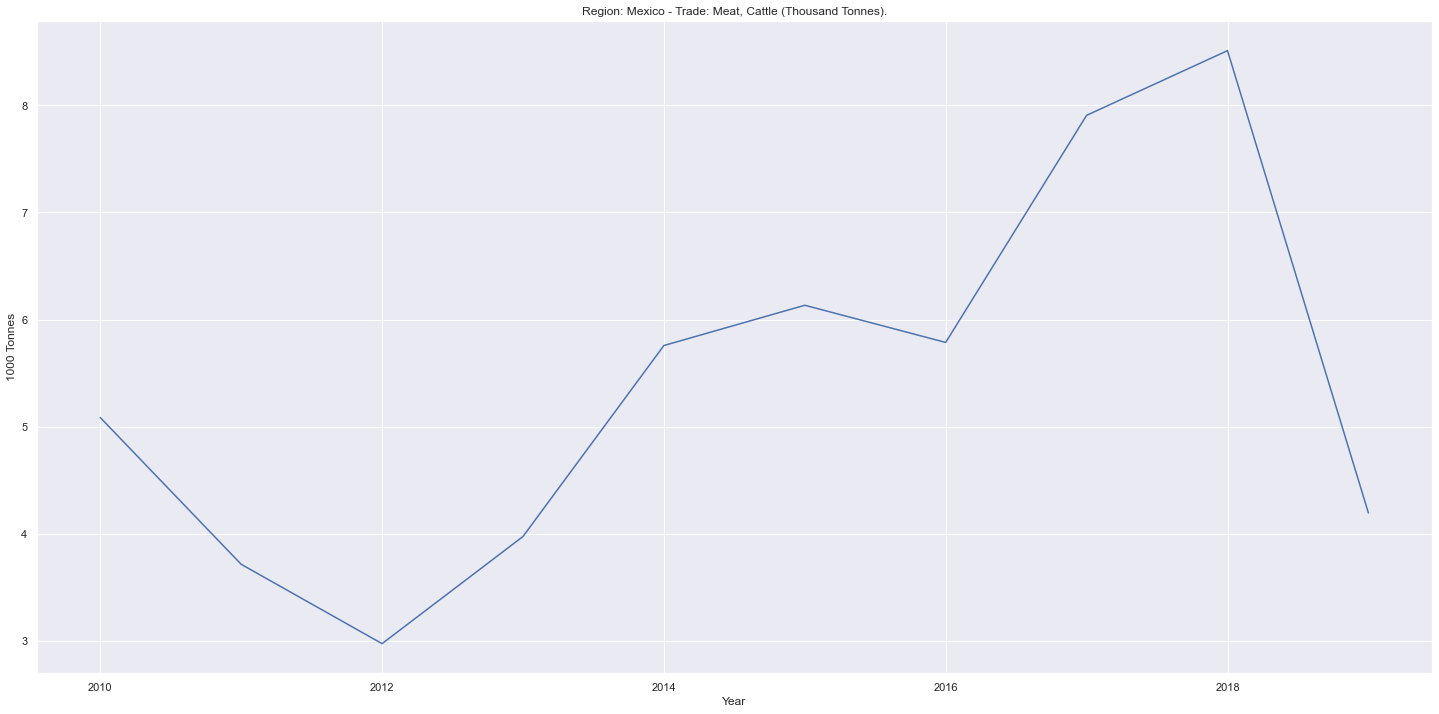

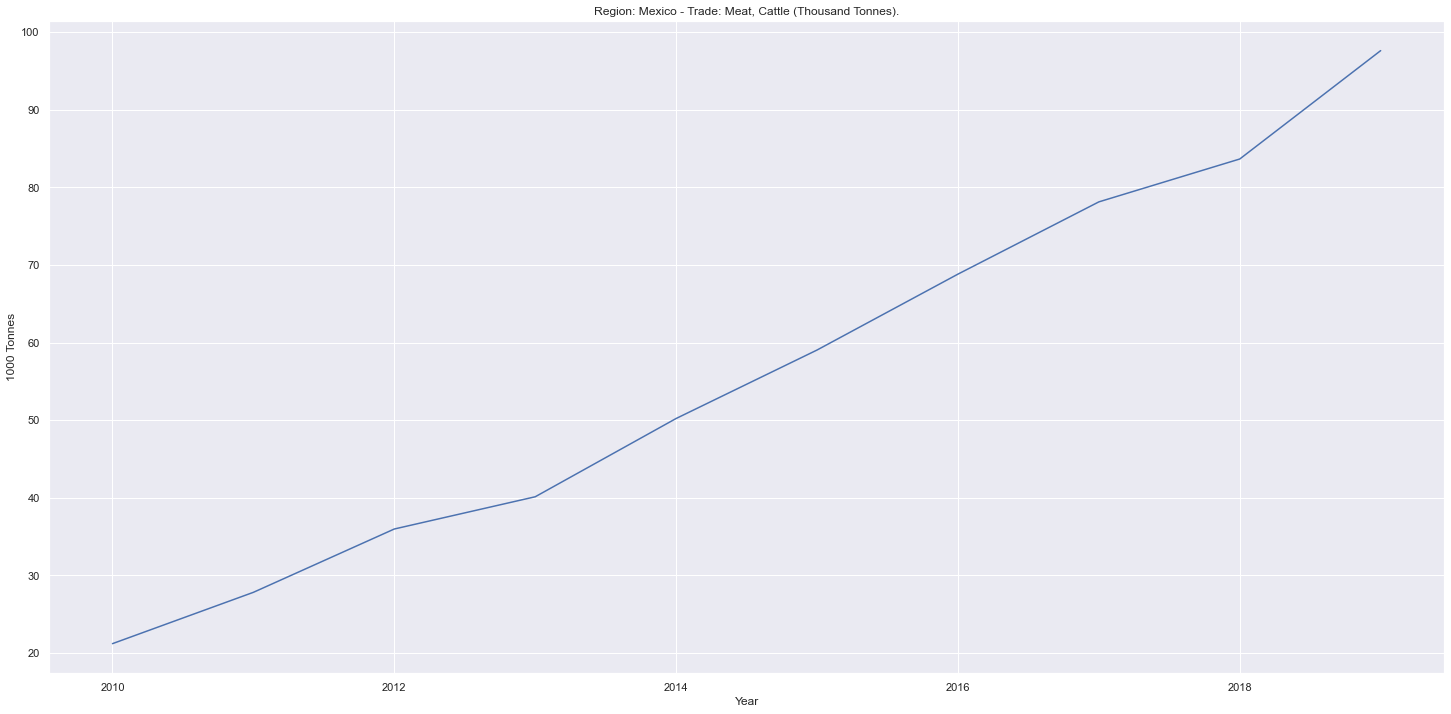

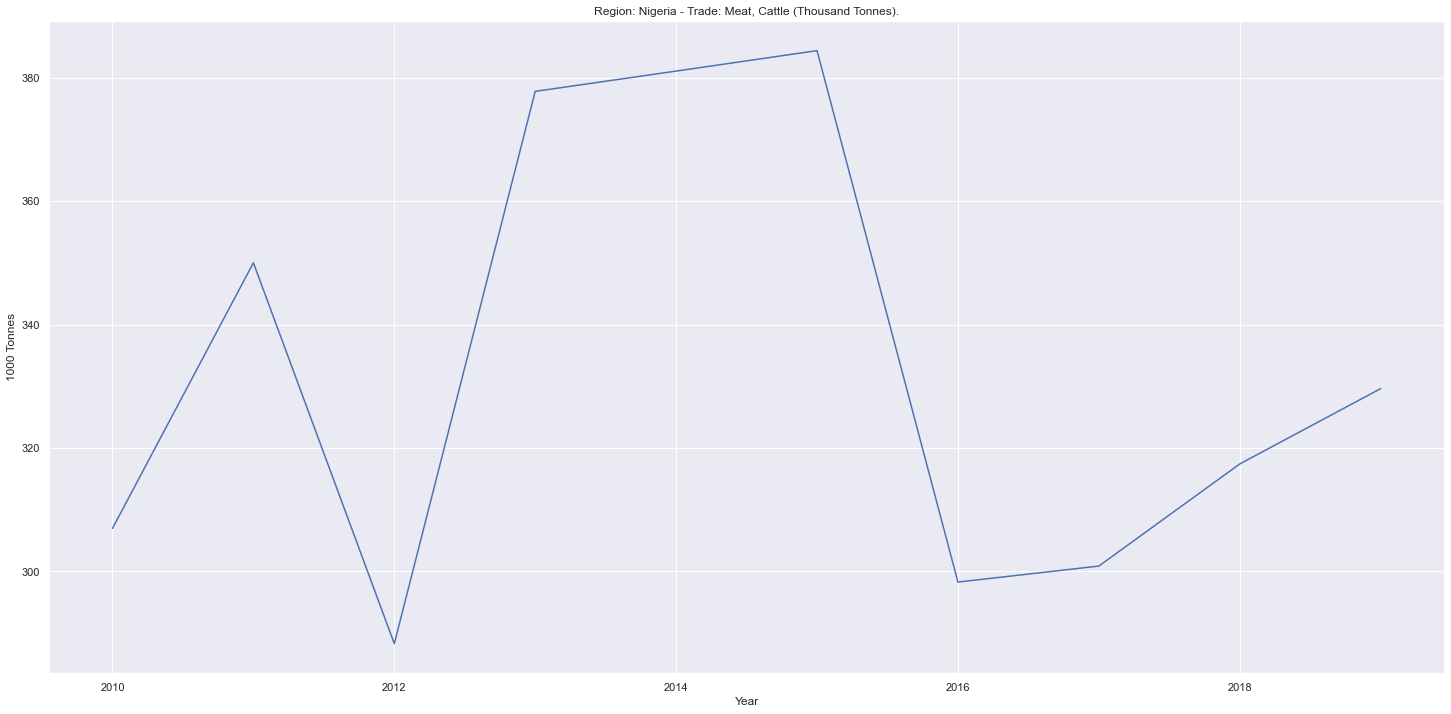

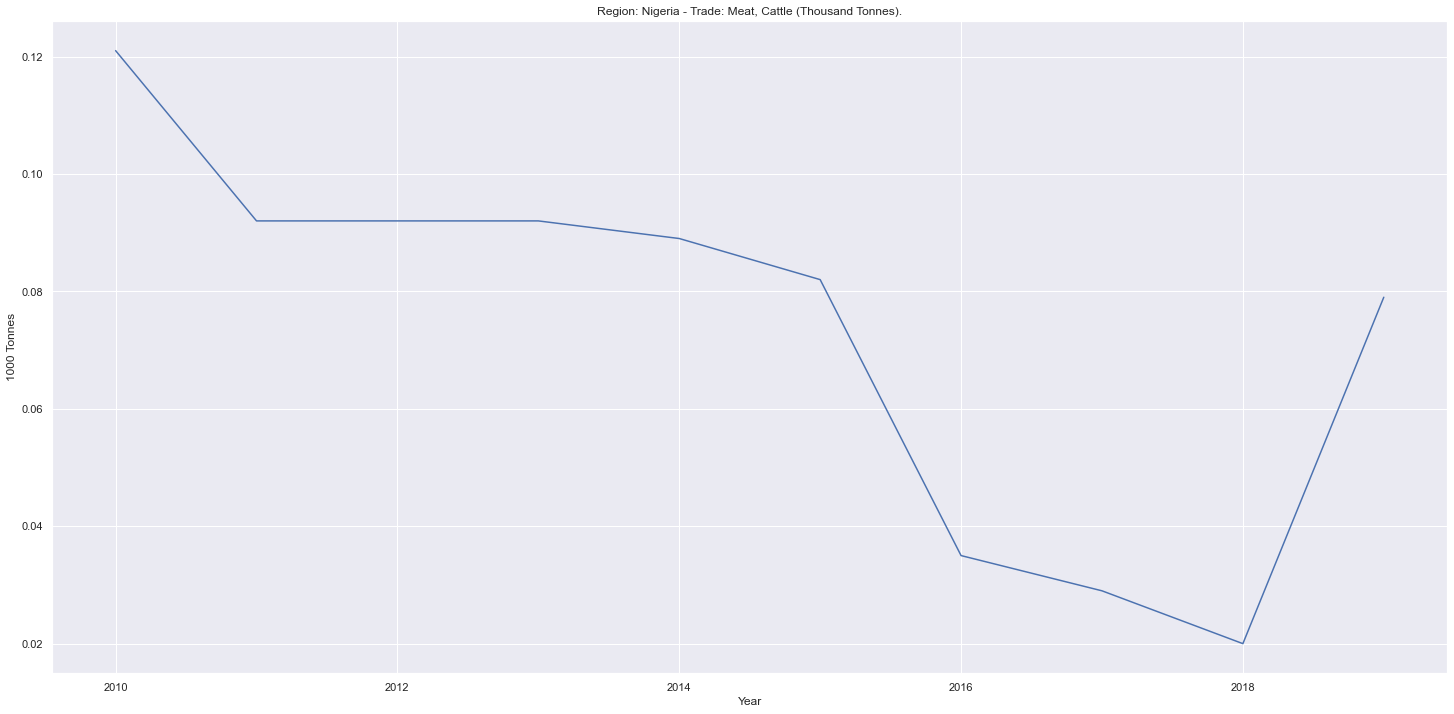

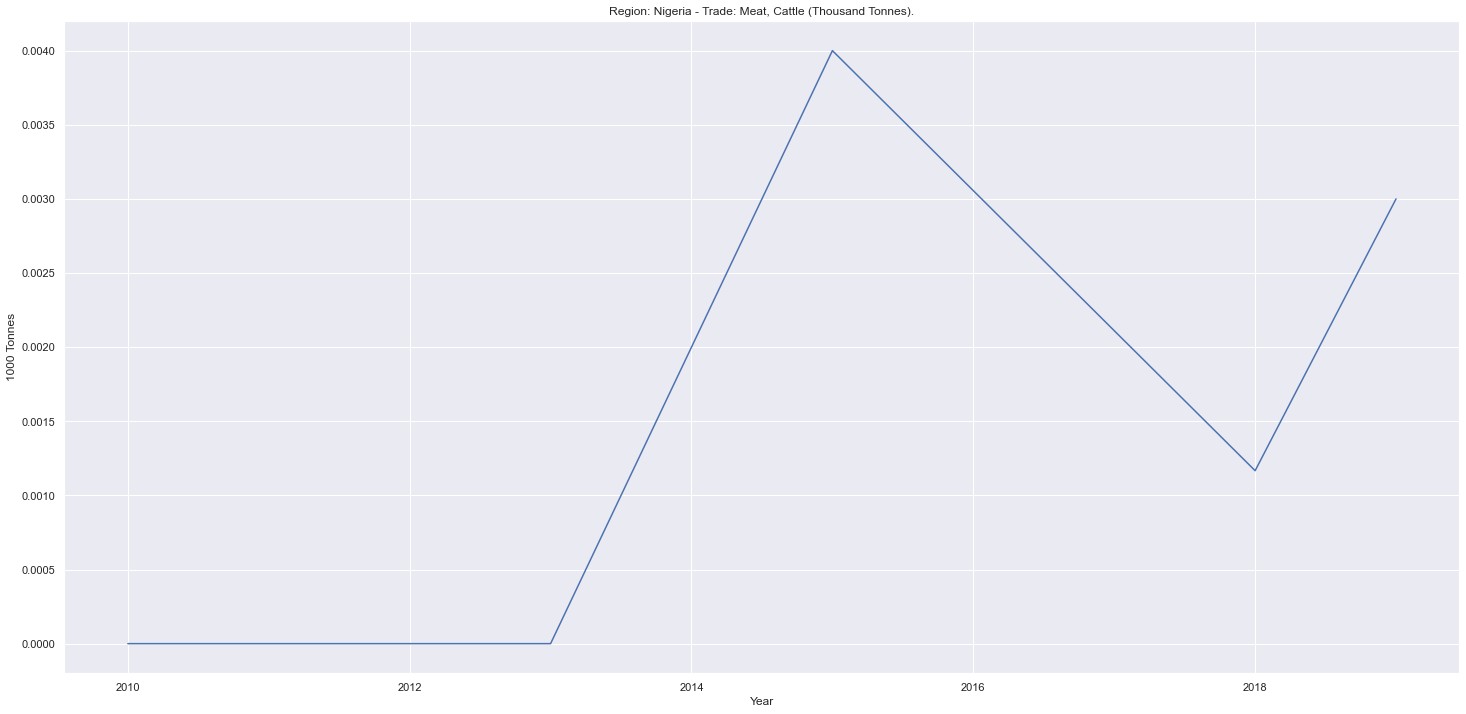

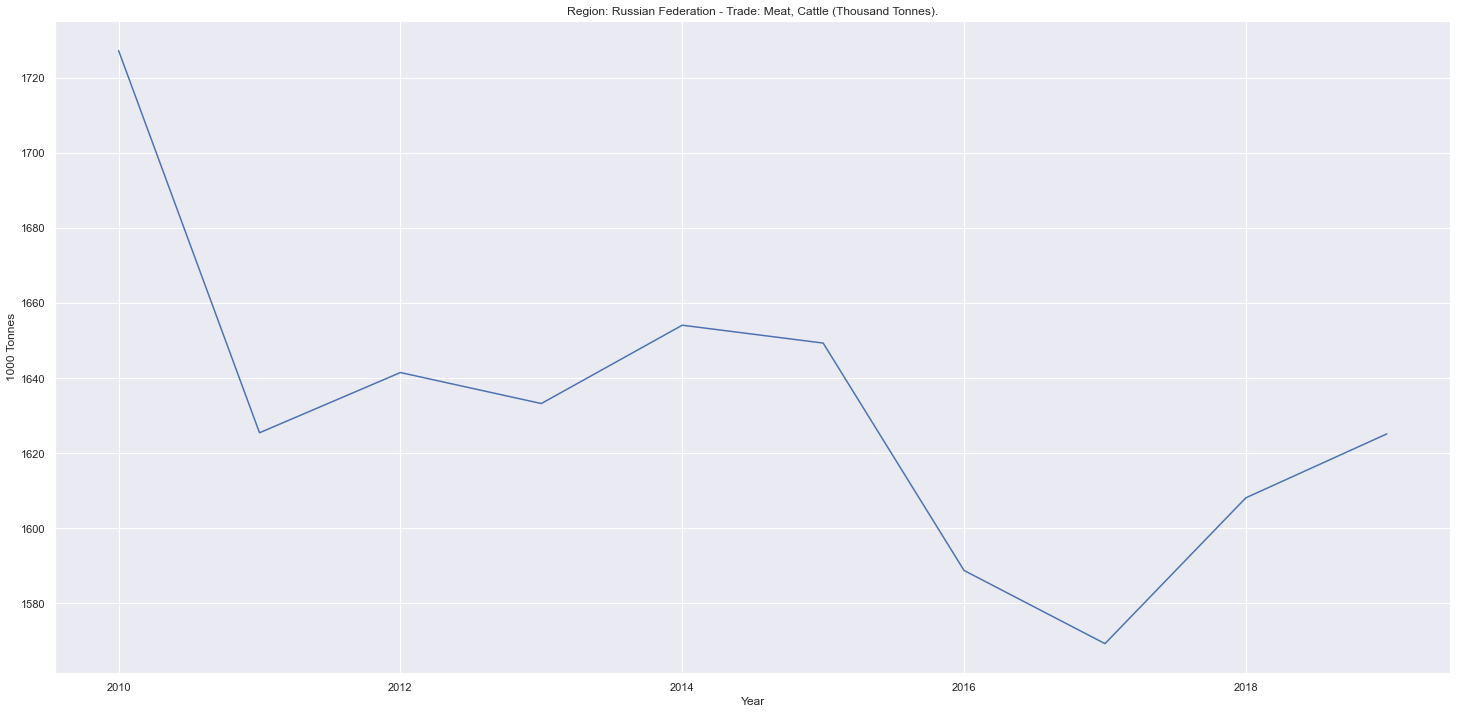

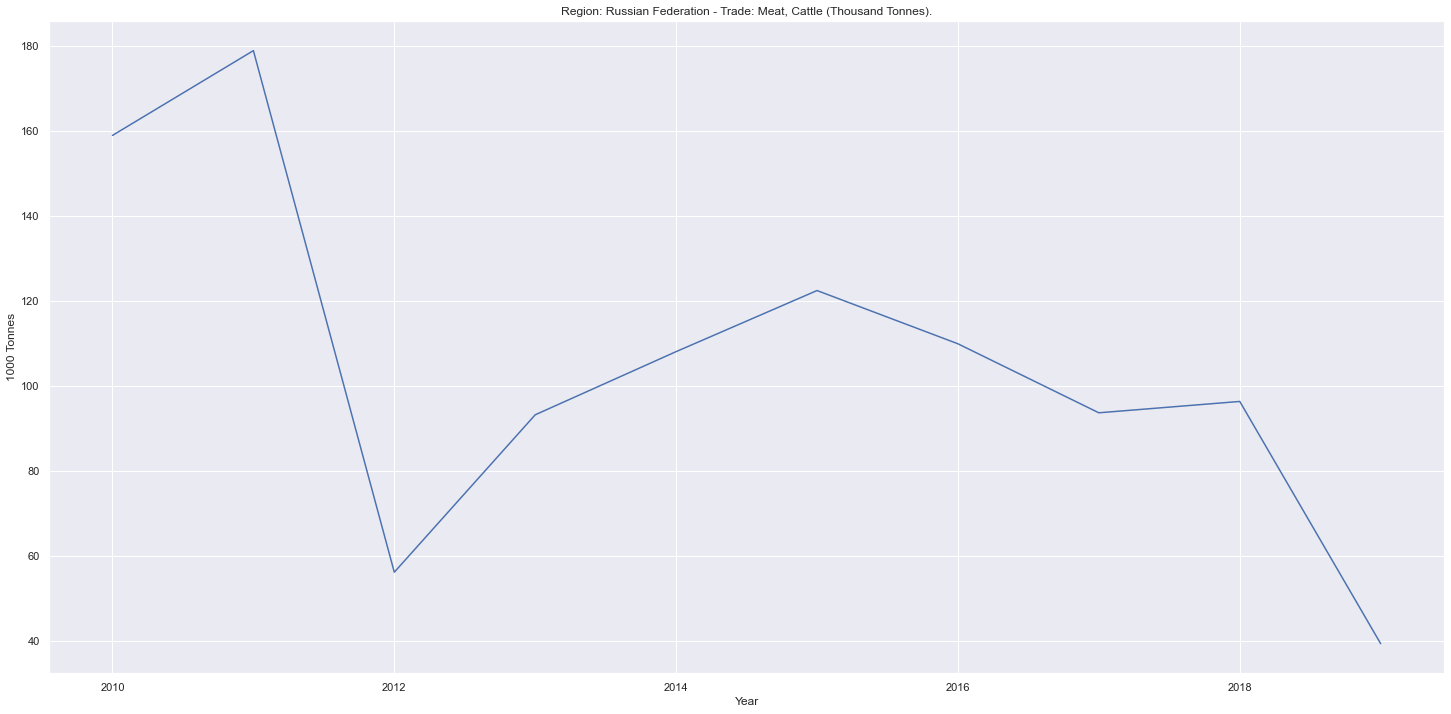

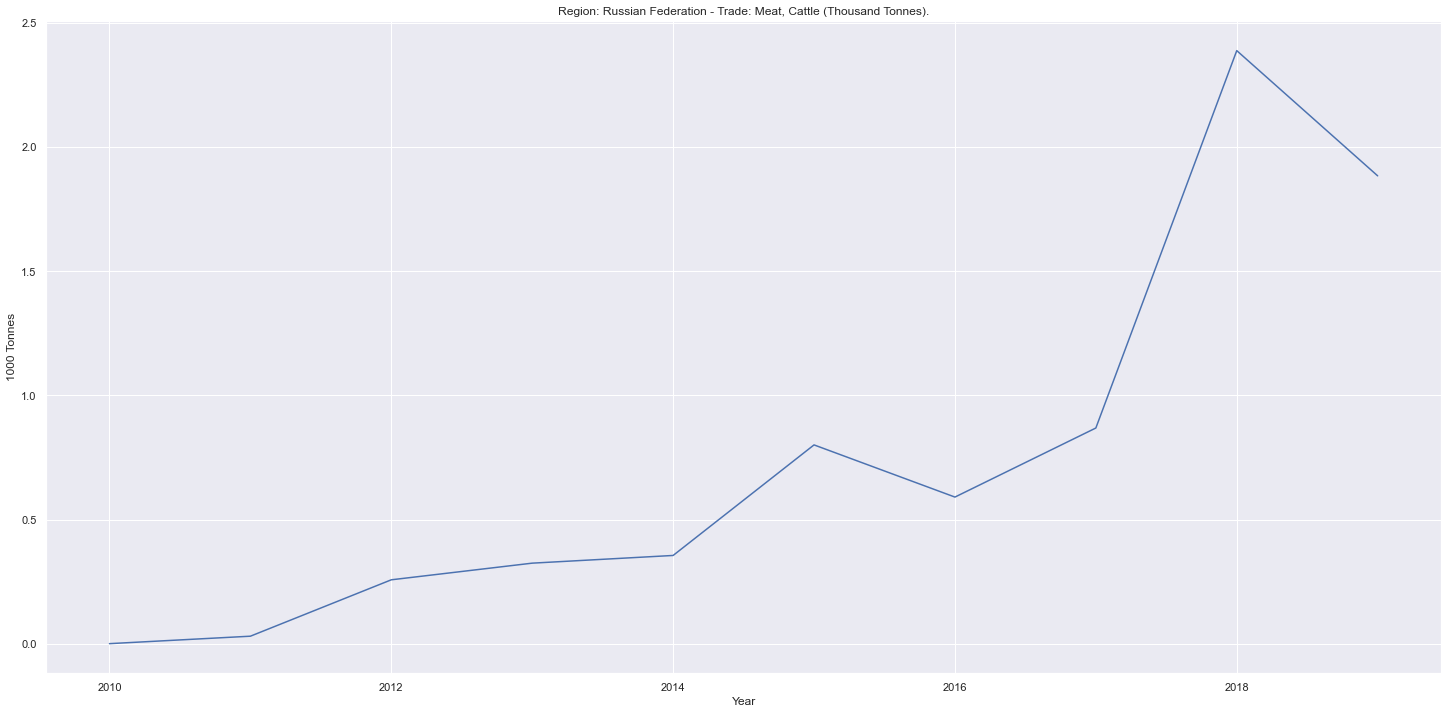

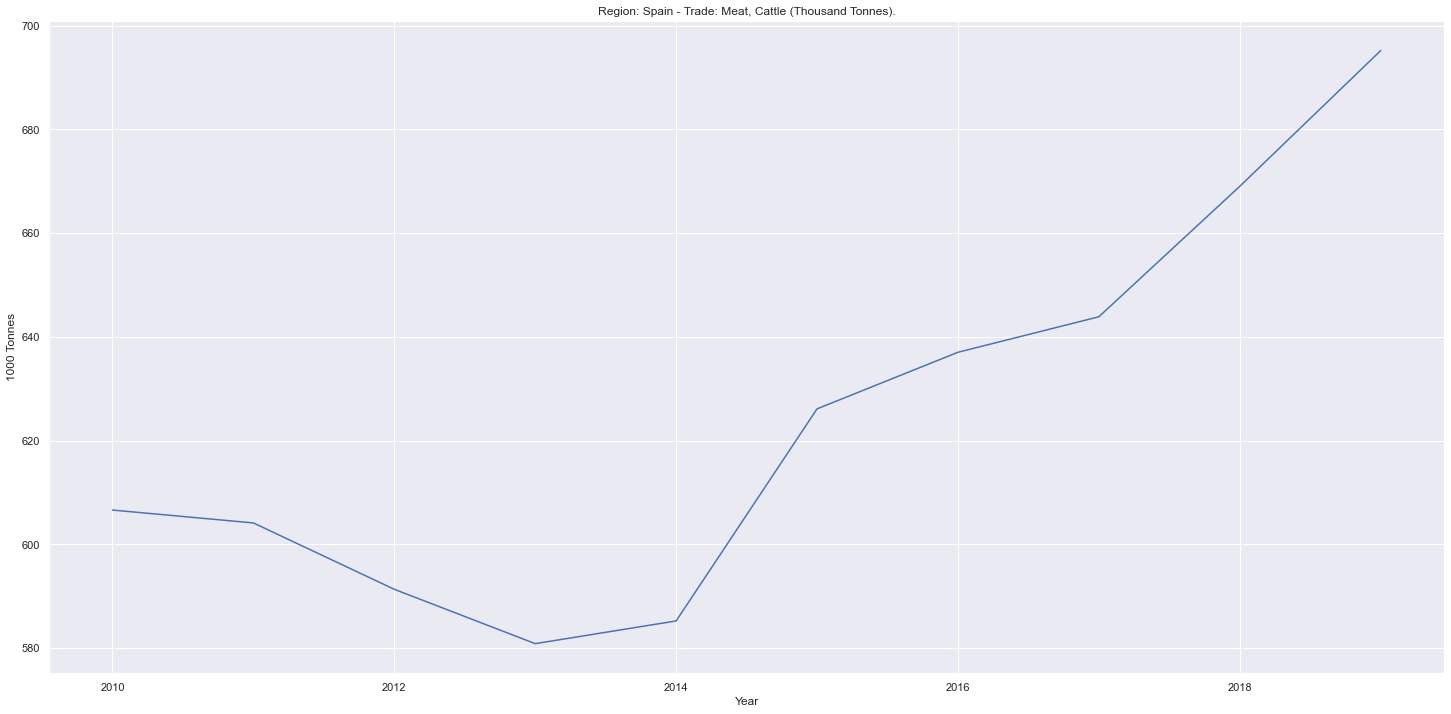

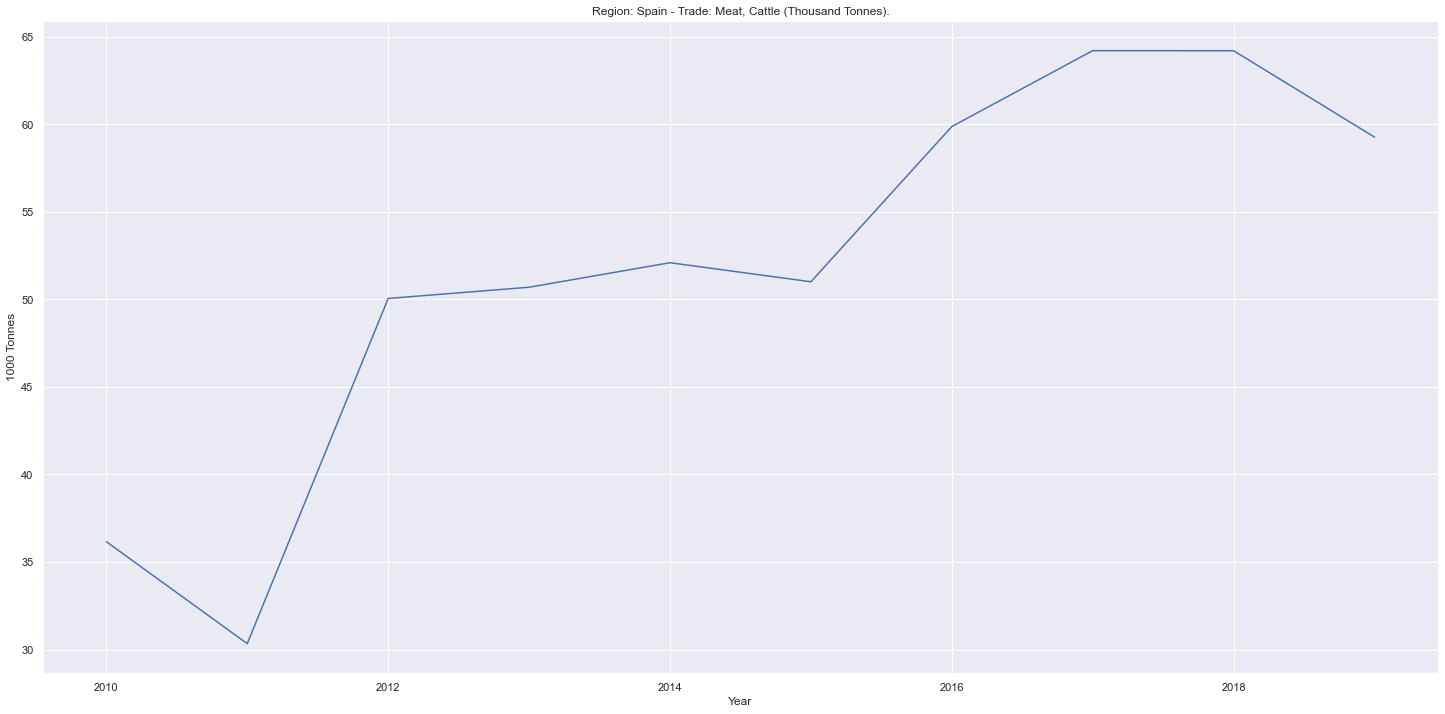

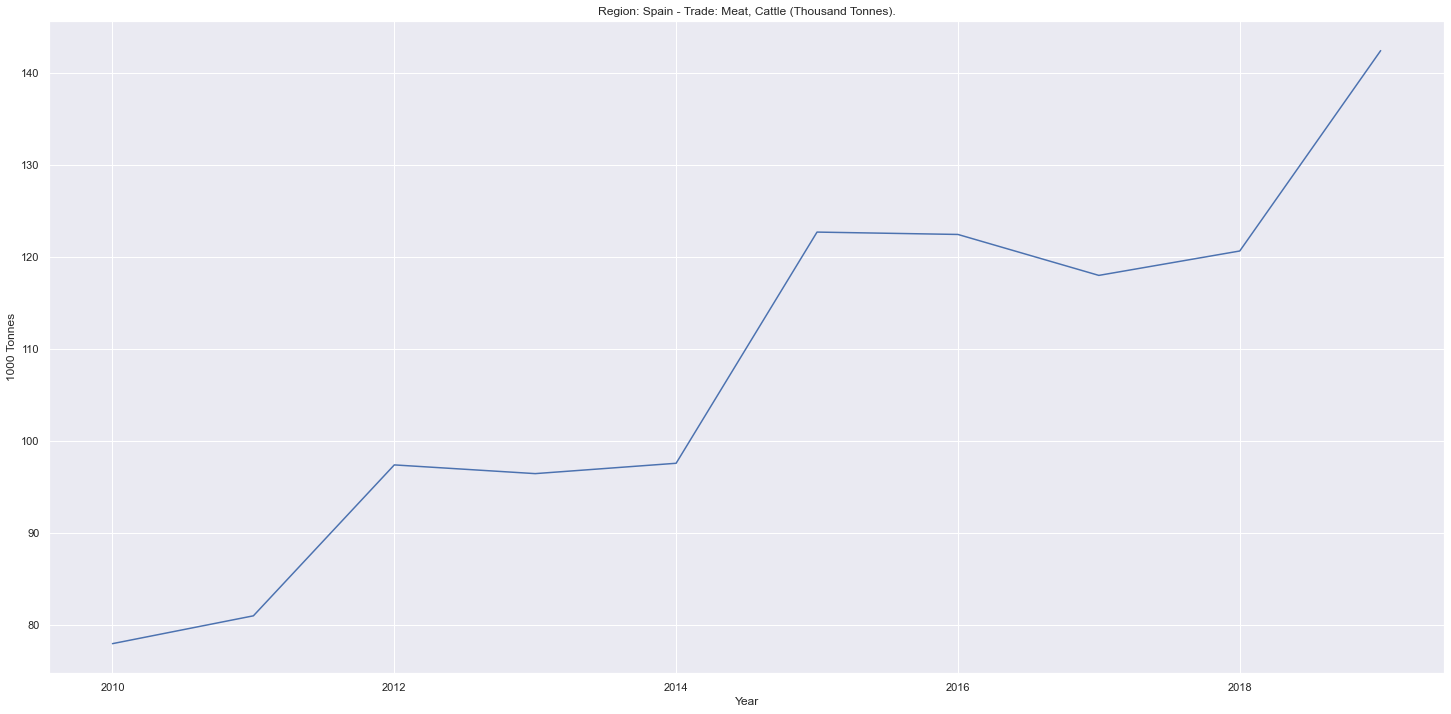

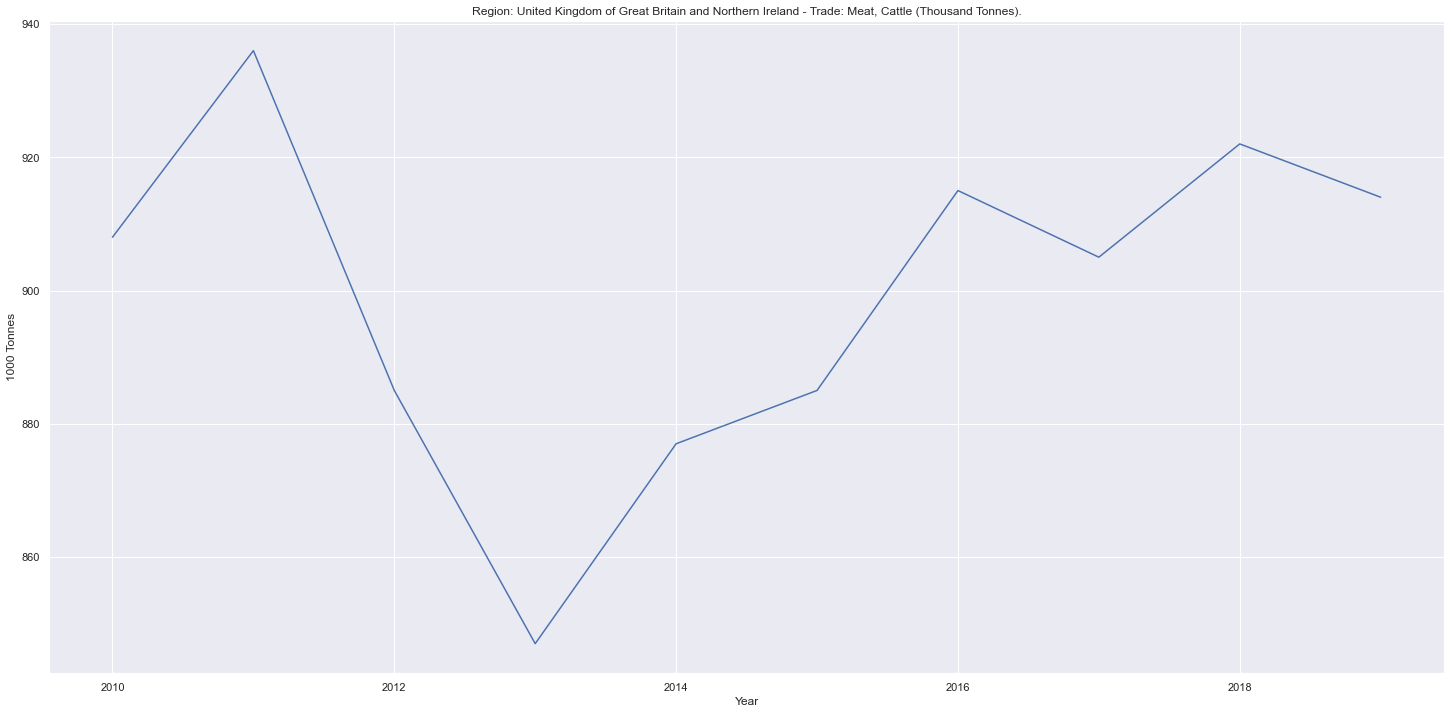

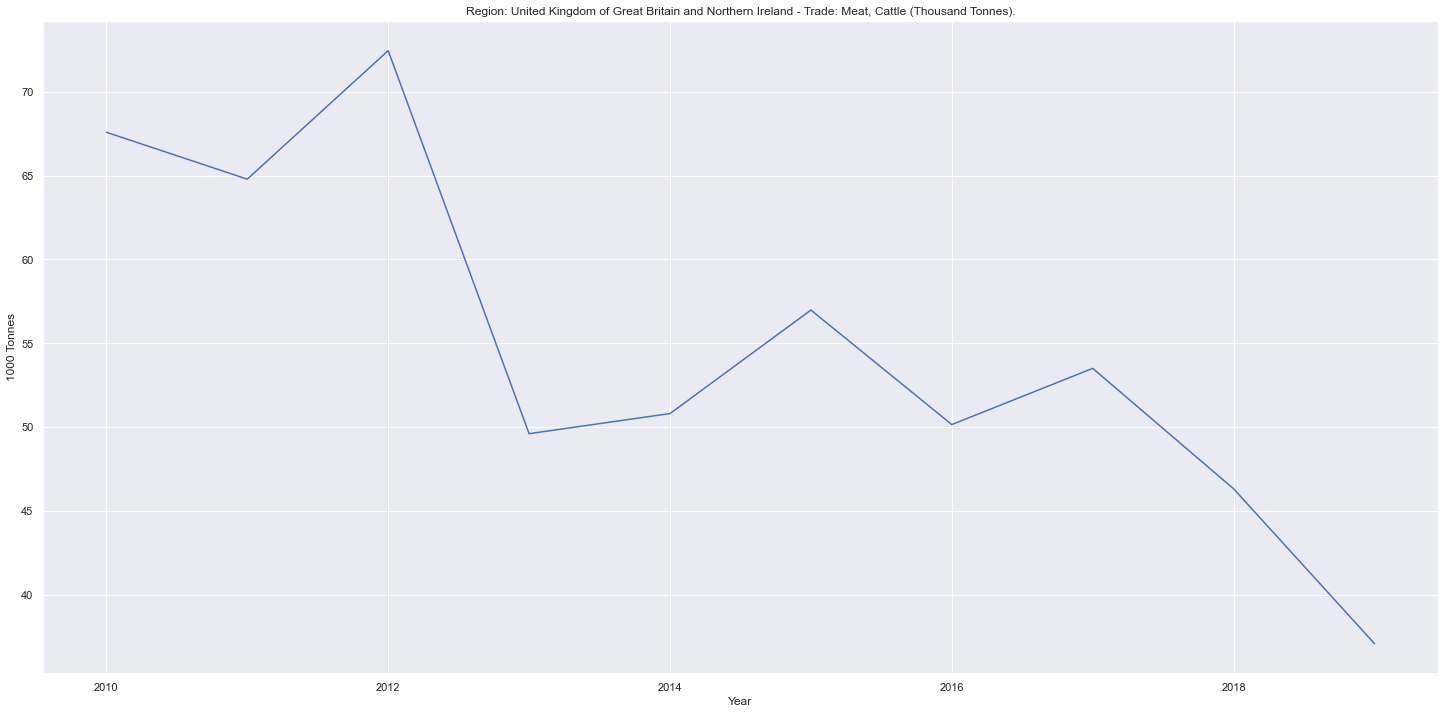

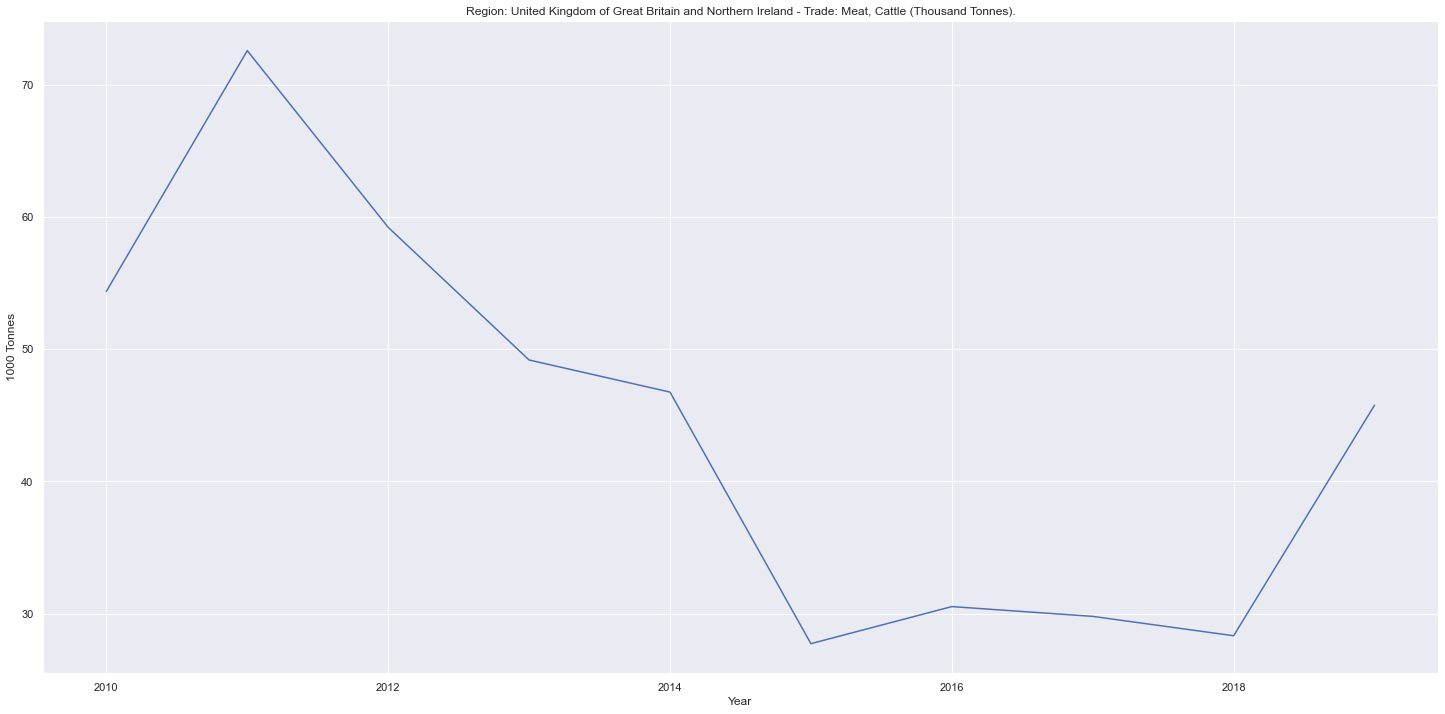

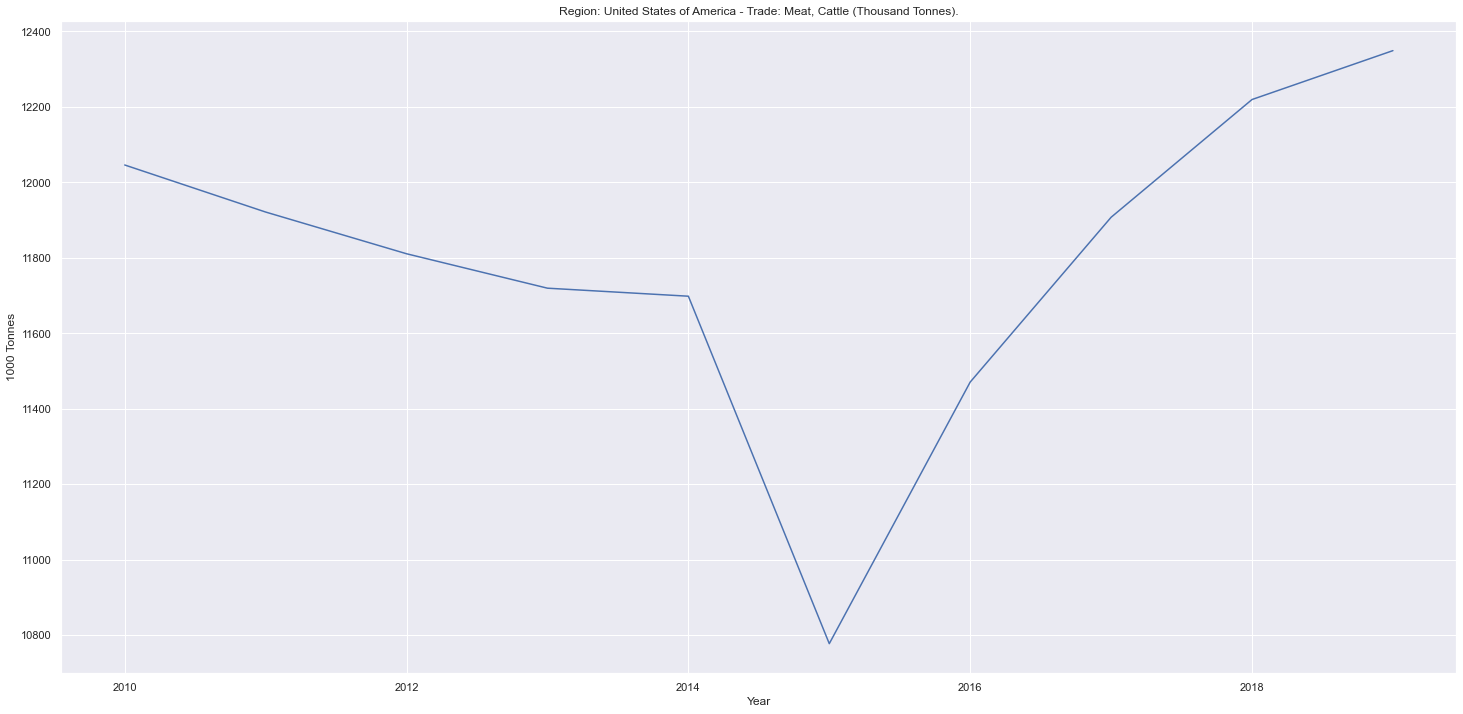

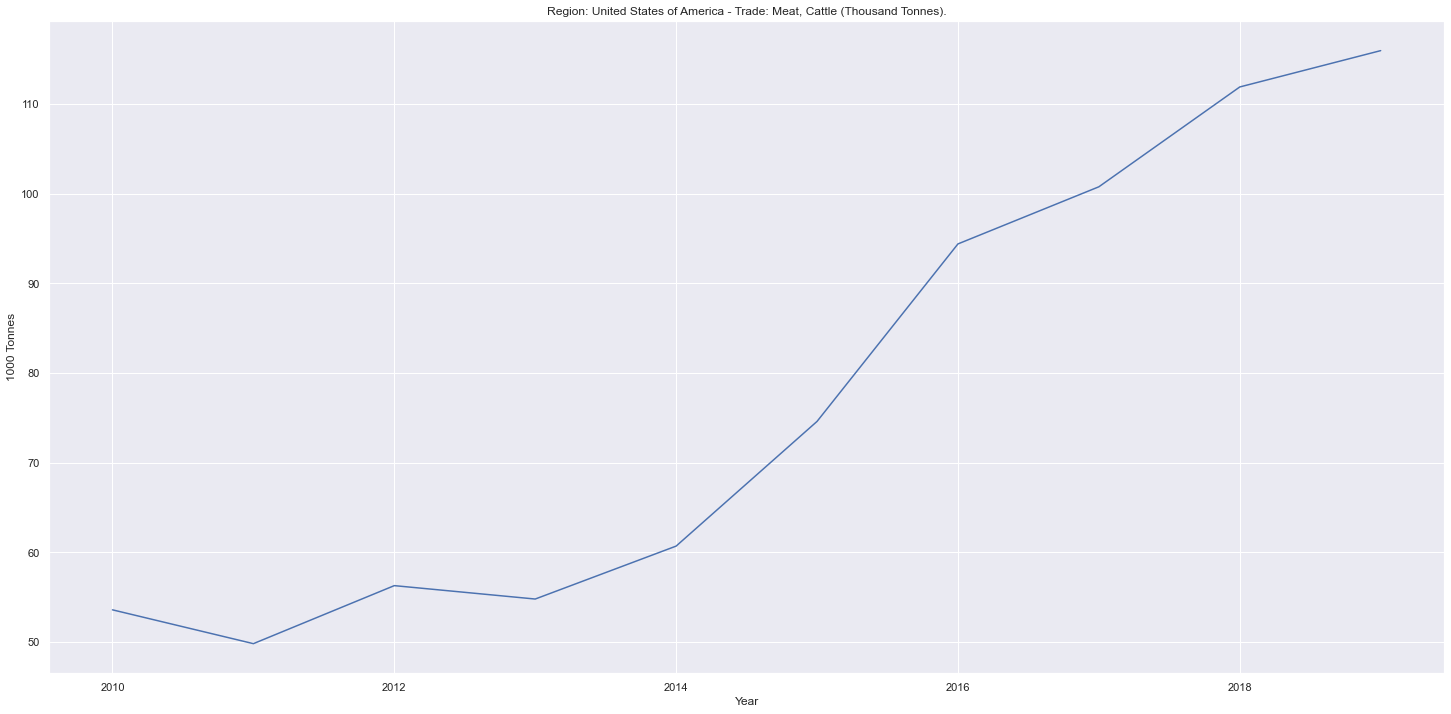

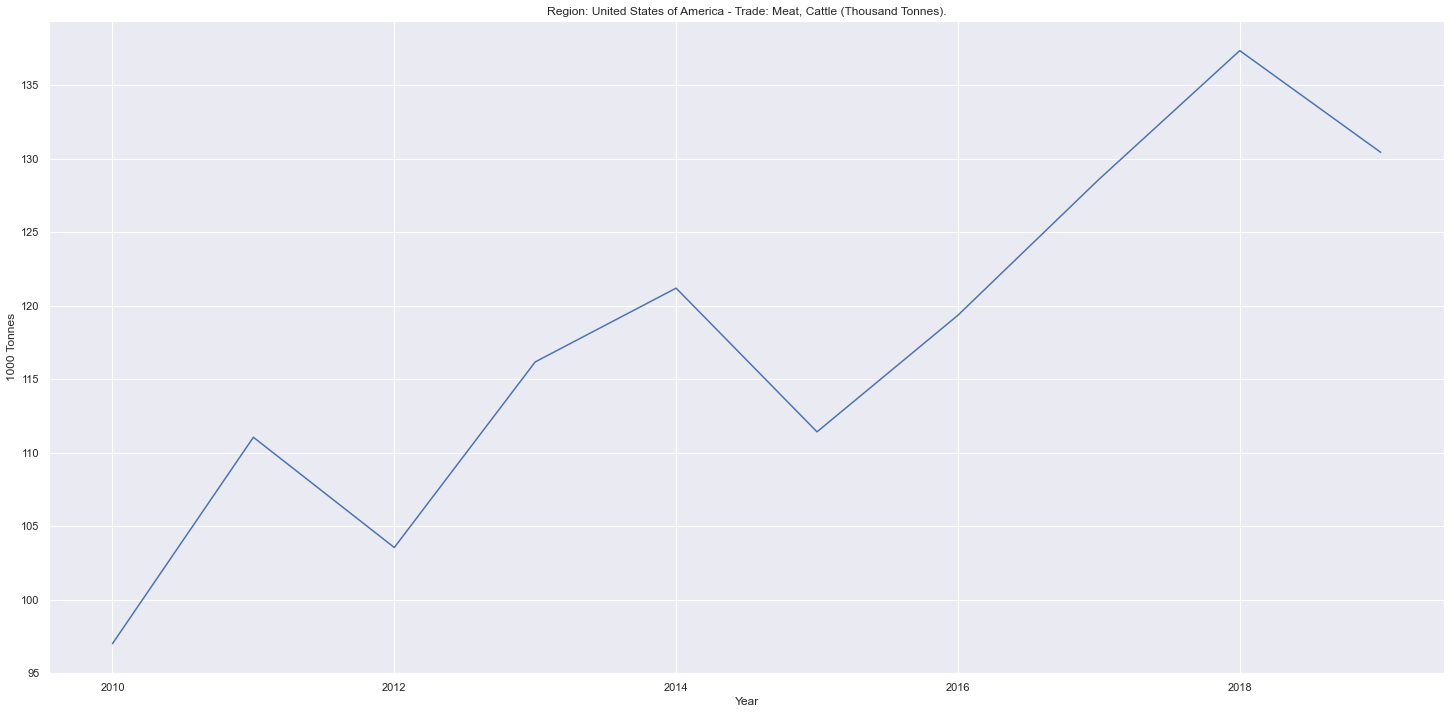

In [22]:
for region in sua_filled_df.Area.unique():
    for element in sua_filled_df.Element.unique():
        plot(sua_filled_df, element, region)

        #Production, Import and Export, respectively. Each Country.

In [23]:
len(sua_filled_df.Element.unique()) * len(sua_filled_df.Area.unique())

57

In [24]:
#Distribution of Elements by Year by Region by item

In [25]:
sua.Item.unique()

array(['Meat, cattle'], dtype=object)

In [26]:
sua.Element.unique()
#'Production', 'Import Quantity', 'Export Quantity'
#'Food supply (kcal/capita/day)', 'Food supply quantity (g/capita/day)', 'Protein supply quantity (g/capita/day)', 'Fat supply quantity (g/capita/day)'

array(['Opening stocks', 'Production', 'Import Quantity',
       'Stock Variation', 'Export Quantity', 'Loss', 'Processed',
       'Tourist consumption', 'Residuals',
       'Food supply quantity (tonnes)', 'Food supply (kcal/capita/day)',
       'Food supply quantity (g/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)', 'Calories/Year',
       'Proteins/Year', 'Fats/Year', 'Other uses (non-food)'],
      dtype=object)

In [27]:
sua.isnull().sum()

Area         0
Item         0
Element      0
Year         0
Unit         0
Value      209
dtype: int64

In [28]:
nutrientflow = ['Cropland nutrient flow']

In [70]:
env_soil_nut = pd.read_csv("Environment_Soil_nutrient_budget.csv",
                           encoding='latin1')
env_soil_nut = env_soil_nut.drop(
    ['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
env_soil_nut = env_soil_nut.loc[env_soil_nut.Area.isin(shortlist_coutries)]
env_soil_nut = env_soil_nut.sort_values(by=["Area", "Item", "Year"])
env_soil_nut.reset_index(inplace=True, drop=True)
env_soil_nut

#Unities according to Element
#Cropland nutrient flow per unit area: kg/ha
#Cropland nutrient flow: tonnes

,Area,Item,Element,Year,Unit,Value
0,Argentina,Atmospheric Deposition,Cropland nutrient flow,1961,tonnes,9.222913e+04
1,Argentina,Atmospheric Deposition,Cropland nutrient flow per unit area,1961,kg/ha,4.736500e+00
2,Argentina,Atmospheric Deposition,Cropland nutrient flow,1962,tonnes,9.541212e+04
3,Argentina,Atmospheric Deposition,Cropland nutrient flow per unit area,1962,kg/ha,4.756100e+00
4,Argentina,Atmospheric Deposition,Cropland nutrient flow,1963,tonnes,9.790055e+04
...,...,...,...,...,...,...
17127,United States of America,Synthetic Fertilizers,Cropland nutrient flow per unit area,2016,kg/ha,7.321090e+01
17128,United States of America,Synthetic Fertilizers,Cropland nutrient flow,2017,tonnes,1.177248e+07
17129,United States of America,Synthetic Fertilizers,Cropland nutrient flow per unit area,2017,kg/ha,7.337770e+01
17130,United States of America,Synthetic Fertilizers,Cropland nutrient flow,2018,tonnes,1.164446e+07


In [ ]:
env_soil_nut.Unit.unique()

array(['kg/ha'], dtype=object)

In [ ]:
env_soil_nut.Item.unique()

array(['Atmospheric Deposition', 'Biological Fixation', 'Crop Removal',
       'Input', 'Manure applied to Soils', 'Outputs',
       'Soil nutrient budget', 'Synthetic Fertilizers'], dtype=object)

In [ ]:
env_soil_nut.Element.unique()

array(['Cropland nutrient flow', 'Cropland nutrient flow per unit area'],
      dtype=object)

In [ ]:
env_soil_nut.isnull().sum()

Area       0
Item       0
Element    0
Year       0
Unit       0
Value      0
dtype: int64

In [ ]:
#plt.figure(figsize=(18,14))
#sns.heatmap(env_soil_nut.corr(),annot=True,linecolor="white",lw=0.5)

In [ ]:
env_soil_nut.dtypes

Area        object
Item        object
Element     object
Year         int64
Unit        object
Value      float64
Flag        object
dtype: object

In [ ]:
env_soil_nut.Item.unique()

array(['Atmospheric Deposition', 'Biological Fixation', 'Crop Removal',
       'Input', 'Manure applied to Soils', 'Outputs',
       'Soil nutrient budget', 'Synthetic Fertilizers'], dtype=object)

In [ ]:
env_soil_nut.Element.unique()

array(['Cropland nutrient flow', 'Cropland nutrient flow per unit area'],
      dtype=object)

In [ ]:
env_soil_nut.Year.unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018])

In [ ]:
env_soil_nut.Unit.unique()

array(['tonnes', 'kg/ha'], dtype=object)

In [ ]:
env_soil_nut.Value.unique()

array([9.22291280e+04, 4.73650000e+00, 9.54121221e+04, ...,
       7.33777000e+01, 1.16444610e+07, 7.25797000e+01])

In [ ]:
env_soil_nut.Flag.unique()

array(['Fc', 'A', 'Qm', 'X', 'Fb', 'W', 'E', '*', 'Fm', 'P'], dtype=object)